In [1]:
import os
import glob
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import xarray as xr
import dask
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import pandas as pd
import datetime
import copy
# %matploblib inline

In [2]:
xr.set_options(display_style='text')

In [10]:
# iclassdir = '/lustre/or-hydra/cades-arm/proj-shared/iclass/cacti/radar_processing/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# stats_file = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'

iclassdir = '/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/'
statsdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/stats/'
terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
stats_file = f'{statsdir}/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
stats_file3d = f'{statsdir}/stats_3d_ppi_20181015.0000_20190303.0000.nc'
sat_file = f'{statsdir}/stats_goes16_20181015.0000_20190303.0000.nc'

# iclassdir = '/Users/feng045/data/cacti/'
# terrain_file = f'{iclassdir}corgridded_terrain.c0/topo_cacti_csapr2_large.nc'
# stats_file = f'{iclassdir}stats/stats_tracknumbersv1.0_20181015.0000_20190303.0000.nc'
# stats_file3d = f'{iclassdir}stats/stats_3d_ppi_20181015.0000_20190303.0000.nc'

radar_lat = -32.1264
radar_lon = -64.7284

# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1/figures/'
# figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.test/figures/'
figdir = f'{iclassdir}taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/'
# figdir = f'/Users/feng045/results/ICLASS/CACTI/CSAPR/figures/figures/'
os.makedirs(figdir, exist_ok=True)

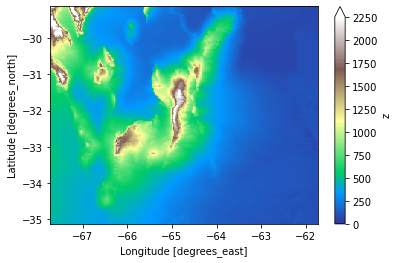

In [11]:
terr = xr.open_dataset(terrain_file)
topoZ = terr['z']
topoLon = terr['x']
topoLat = terr['y']
# topoZ = terr.hgt
# topoLon = terr.longitude
# topoLat = terr.latitude

topoZ.plot(vmin=0, vmax=2250, cmap='terrain')

In [22]:
# Read 2D track data
stats2d = xr.open_dataset(stats_file)
time_res = stats2d.attrs['time_resolution_hour']
pixel_radius = stats2d.attrs['pixel_radius_km']
stats2d.dims['tracks']

6895

In [23]:
# Read 3D data
stats3d = xr.open_dataset(stats_file3d)
stats3d.dims['tracks']

6895

In [24]:
# Read satellite data
sat = xr.open_dataset(sat_file, drop_variables=['basetime', 'cell_area'])
sat.dims['tracks']

6895

In [25]:
# Combine 2D and 3D datasets by coordinates
stats = xr.combine_by_coords([stats2d, stats3d, sat], combine_attrs='override')
stats

<xarray.Dataset>
Dimensions:                    (times: 60, tracks: 6895, z: 45)
Coordinates:
  * tracks                     (tracks) int32 0 1 2 3 4 ... 6891 6892 6893 6894
  * times                      (times) int32 0 1 2 3 4 5 6 ... 54 55 56 57 58 59
  * z                          (z) float64 0.0 500.0 1e+03 ... 2.15e+04 2.2e+04
Data variables: (12/71)
    cloud_top_temperature_min  (tracks, times) float32 ...
    temperature_ir_min         (tracks, times) float32 ...
    cloud_top_height_max       (tracks, times) float32 ...
    cloud_top_pressure_min     (tracks, times) float32 ...
    area_liquid                (tracks, times) float32 ...
    area_ice                   (tracks, times) float32 ...
    ...                         ...
    max_zdr                    (tracks, times, z) float32 ...
    max_kdp                    (tracks, times, z) float32 ...
    max_rainrate               (tracks, times, z) float32 ...
    max_Dm                     (tracks, times, z) float32 ...
    max_lwc                    (tracks, times, z) float32 ...
    volrain                    (tracks, times, z) float32 ...
Attributes:
    title:             Track statistics
    Institution:       Pacific Northwest National Laboratoy
    Contact:           Zhe Feng, zhe.feng@pnnl.gov
    Created_on:        Fri Feb 26 21:39:11 2021
    source_trackfile:  /global/cscratch1/sd/feng045/iclass/cacti/arm/csapr/ta...
    startdate:         20181015.0000
    enddate:           20190303.0000

In [27]:
tracks = stats['tracks']
times = stats['times']
height = stats['z'] / 1000.
# time_res = stats.attrs['time_resolution_hour']
# pixel_radius = stats.attrs['pixel_radius_km']
print(f'Number of total tracks: {len(tracks)}')

# Get cell initial location
cell_lon0 = stats['cell_meanlon'].isel(times=0)
# Remove NaN
ind = np.where(~np.isnan(cell_lon0))[0]
ntracks = len(ind)
print(f'Number of valid tracks: {ntracks}')

# Subset tracks for the entire dataset
stats = stats.isel(tracks=ind)
stats.dims['tracks']

Number of total tracks: 6887
Number of valid tracks: 6887


6887

In [50]:
lifetime = stats['lifetime'] * time_res
start_time = stats['start_basetime']
end_time = stats['end_basetime']
end_merge_tracknumber = stats['end_merge_tracknumber']
start_split_tracknumber = stats['start_split_tracknumber']
cell_lon = stats['cell_meanlon']
cell_lat = stats['cell_meanlat']
cell_area = stats['cell_area']
maxdbz = stats['maxdbz']
maxrange_flag = stats['maxrange_flag']

eth10 = stats['maxETH_10dbz']
eth20 = stats['maxETH_20dbz']
eth30 = stats['maxETH_30dbz']
eth40 = stats['maxETH_40dbz']
eth50 = stats['maxETH_50dbz']

ctt = stats['cloud_top_temperature_min']
cth = stats['cloud_top_height_max']

In [48]:
# lifetime = lifetime.isel(tracks=ind)
# start_time = start_time.isel(tracks=ind)
# end_time = end_time.isel(tracks=ind)
# end_merge_tracknumber = end_merge_tracknumber.isel(tracks=ind)
# start_split_tracknumber = start_split_tracknumber.isel(tracks=ind)
# cell_lon = cell_lon.isel(tracks=ind)
# cell_lat = cell_lat.isel(tracks=ind)
# cell_area = cell_area.isel(tracks=ind)
# maxrange_flag = maxrange_flag.isel(tracks=ind)
# eth10 = eth10.isel(tracks=ind)
# eth20 = eth20.isel(tracks=ind)
# eth30 = eth30.isel(tracks=ind)
# eth40 = eth40.isel(tracks=ind)
# eth50 = eth50.isel(tracks=ind)

In [30]:
# Get track start values
start_maxrange_flag = maxrange_flag.isel(times=0)
start_lon = cell_lon.isel(times=0)
start_lat = cell_lat.isel(times=0)

# Get duration (lifetime counts) and maxrange_flag in Numpy arrays for speed
duration = (lifetime.values / time_res).astype(int)
rangeflag = maxrange_flag.values.astype(int)
celllon = cell_lon.values
celllat = cell_lat.values

end_maxrange_flag = np.ones(ntracks, dtype=int)
end_lon = np.full(ntracks, np.NaN, dtype=float)
end_lat = np.full(ntracks, np.NaN, dtype=float)

# Get track last valid value
for ii in range(0, ntracks):
    # Get duration for the track
    iduration = duration[ii]
    # Get valid values for the track
    imaxrangeflag = rangeflag[ii,0:iduration]
    icell_lon = celllon[ii,0:iduration]
    icell_lat = celllat[ii,0:iduration]
    
    # Get last value from the track
    end_maxrange_flag[ii] = imaxrangeflag[-1]
    end_lon[ii] = icell_lon[-1]
    end_lat[ii] = icell_lat[-1]

In [31]:
# Get track start/end hour
start_hour = start_time.dt.hour
end_hour = end_time.dt.hour

# Find tracks not end with merge or not start with split
nonmerge = np.where(np.isnan(end_merge_tracknumber))[0]
nonsplit = np.where(np.isnan(start_split_tracknumber))[0]
ntracks_nonmerge = len(nonmerge)
ntracks_nonsplit = len(nonsplit)
print(f'Number of non-merge tracks: {ntracks_nonmerge}')
print(f'Number of non-split tracks: {ntracks_nonsplit}')

nonsplit_in = np.where(np.isnan(start_split_tracknumber) & (start_maxrange_flag == 1))[0]
nonmerge_in = np.where(np.isnan(end_merge_tracknumber) & (end_maxrange_flag == 1))[0]
ntracks_nonsplit_in = len(nonsplit_in)
ntracks_nonmerge_in = len(nonmerge_in)
print(f'Number of non-split tracks within max range: {ntracks_nonsplit_in}')
print(f'Number of non-merge tracks within max range: {ntracks_nonmerge_in}')

merge = np.where(end_merge_tracknumber > 0)[0]
split = np.where(start_split_tracknumber > 0)[0]
ntracks_merge = len(merge)
ntracks_split = len(split)
print(f'Number of merge tracks: {ntracks_merge}')
print(f'Number of split tracks: {ntracks_split}')

Number of non-merge tracks: 5284
Number of non-split tracks: 5359
Number of non-split tracks within max range: 4854
Number of non-merge tracks within max range: 4528
Number of merge tracks: 1603
Number of split tracks: 1528


In [32]:
cell_diam = 2 * np.sqrt(cell_area / np.pi)
cell_diam_max = cell_diam.max(dim='times')
cell_eth20_max = eth20.max(dim='times')

In [33]:
start_hour.shape, start_lon.shape

((6887,), (6887,))

In [34]:
# Find tracks initiation east of SDC during the day (12PM - 8PM)
# LT = UTC + 3
# Approximate longitude of SDC ridge
# lon_SDC = -64.9
lon_SDC = -65
# Day/night hour range in UTC
# UTChour_day = [15,22]
# UTChour_night = [0,8]
UTChour_day = [0,23]
UTChour_night = [0,23]
idx_eSDC_day = np.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC))[0]
start_lon_eSDC_day = start_lon.isel(tracks=idx_eSDC_day)
start_lat_eSDC_day = start_lat.isel(tracks=idx_eSDC_day)
lifetime_eSDC_day = lifetime.isel(tracks=idx_eSDC_day)
ntracks_eSDC = len(idx_eSDC_day)
print(f'Number of tracks (eSDC day): {ntracks_eSDC}')
# start_lon_eSDC_day.shape, start_lat_eSDC_day.shape

idx_wSDC_night = np.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC))[0]
start_lon_wSDC_night = start_lon.isel(tracks=idx_wSDC_night)
start_lat_wSDC_night = start_lat.isel(tracks=idx_wSDC_night)
lifetime_wSDC_night = lifetime.isel(tracks=idx_wSDC_night)
ntracks_wSDC = len(idx_wSDC_night)
print(f'Number of tracks (wSDC night): {ntracks_wSDC}')

Number of tracks (eSDC day): 4918
Number of tracks (wSDC night): 1969


Day LT: [21 20]
Night LT: [21 20]


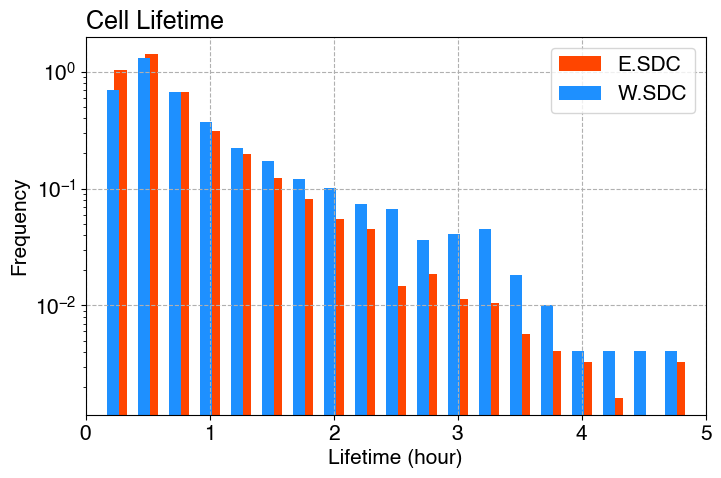

In [35]:
mpl.rcParams['font.size'] = 15
mpl.rcParams['font.family'] = 'Helvetica'
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), dpi=100)

# Convert to LT for legend
LThour_day = np.array(UTChour_day) - 3
LThour_day[LThour_day < 0] = LThour_day[LThour_day < 0] + 24
LThour_night = np.array(UTChour_night) - 3 
LThour_night[LThour_night < 3] = LThour_night[LThour_night < 0] + 24
print(f'Day LT: {LThour_day}')
print(f'Night LT: {LThour_night}')

lifetime_bins = np.arange(21)*0.25

ax1.set_xlabel('Lifetime (hour)')
# ax1.set_ylabel('Number of Tracks')
# hist_eSDC, bins = np.histogram(lifetime_eSDC_day, bins=lifetime_bins, density=False)
# hist_wSDC, bins = np.histogram(lifetime_wSDC_night, bins=lifetime_bins, density=False)
# ax1.bar(lifetime_bins[:-1]+0.03, hist_eSDC, width=0.1, color='orangered', label=f'E.SDC ({LThour_day[0]} - {LThour_day[1]} LT)')
# ax1.bar(lifetime_bins[:-1]-0.03, hist_wSDC, width=0.1, color='dodgerblue', label=f'W.SDC ({LThour_night[0]} - {LThour_night[1]} LT)')
ax1.set_ylabel('Frequency')
hist_eSDC, bins = np.histogram(lifetime_eSDC_day, bins=lifetime_bins, density=True)
hist_wSDC, bins = np.histogram(lifetime_wSDC_night, bins=lifetime_bins, density=True)
ax1.bar(lifetime_bins[:-1]+0.03, hist_eSDC, width=0.1, color='orangered', label=f'E.SDC')
ax1.bar(lifetime_bins[:-1]-0.03, hist_wSDC, width=0.1, color='dodgerblue', label=f'W.SDC')
ax1.legend()
ax1.set_xlim(0, 5)
ax1.set_title('Cell Lifetime', loc='left')
ax1.grid(ls='--')
ax1.set_yscale('log')
fig.savefig(f'{figdir}celltrack_lifetime_pdf_eSDC_wSDC.png', bbox_inches='tight', dpi=300)

In [36]:
stats.cell_area.shape

(6887, 60)

In [37]:
cell_diam.shape, eth20.shape

((6887, 60), (6887, 60))

In [44]:
lifetime_range1 = [0.4,0.5]
lifetime_range2 = [0.9,1]
# lifetime_range3 = [1.6,2.3]
lifetime_range3 = [1.7,2.1]
cell_area1_eSDC = cell_area.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                   (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
cell_area2_eSDC = cell_area.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                   (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
cell_area3_eSDC = cell_area.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC)& 
                                   (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
ntracks1_eSDC = cell_area1_eSDC.sizes['tracks']
ntracks2_eSDC = cell_area2_eSDC.sizes['tracks']
ntracks3_eSDC = cell_area3_eSDC.sizes['tracks']
print(f'Number of tracks: {ntracks1_eSDC}, {ntracks2_eSDC}, {ntracks3_eSDC}')

quantiles_2Dvar = [0.25,0.5,0.75,0.9,0.95]
cell_area1_eSDC_pts = cell_area1_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
cell_area2_eSDC_pts = cell_area2_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
cell_area3_eSDC_pts = cell_area3_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
# Convert area to diameter
cell_diam1_eSDC_pts = 2 * np.sqrt(cell_area1_eSDC_pts / np.pi)
cell_diam2_eSDC_pts = 2 * np.sqrt(cell_area2_eSDC_pts / np.pi)
cell_diam3_eSDC_pts = 2 * np.sqrt(cell_area3_eSDC_pts / np.pi)

Number of tracks: 1572, 351, 149


In [45]:
cell_area1_wSDC = cell_area.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                   (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
cell_area2_wSDC = cell_area.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                   (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
cell_area3_wSDC = cell_area.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC)& 
                                   (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
ntracks1_wSDC = cell_area1_wSDC.sizes['tracks']
ntracks2_wSDC = cell_area2_wSDC.sizes['tracks']
ntracks3_wSDC = cell_area3_wSDC.sizes['tracks']
print(f'Number of tracks: {ntracks1_wSDC}, {ntracks2_wSDC}, {ntracks3_wSDC}')

cell_area1_wSDC_pts = cell_area1_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
cell_area2_wSDC_pts = cell_area2_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
cell_area3_wSDC_pts = cell_area3_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
# Convert area to diameter
cell_diam1_wSDC_pts = 2 * np.sqrt(cell_area1_wSDC_pts / np.pi)
cell_diam2_wSDC_pts = 2 * np.sqrt(cell_area2_wSDC_pts / np.pi)
cell_diam3_wSDC_pts = 2 * np.sqrt(cell_area3_wSDC_pts / np.pi)

Number of tracks: 568, 157, 99


In [51]:
maxdbz1_eSDC = maxdbz.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                   (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
maxdbz2_eSDC = maxdbz.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                   (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
maxdbz3_eSDC = maxdbz.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC)& 
                                   (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
maxdbz1_eSDC_pts = maxdbz1_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
maxdbz2_eSDC_pts = maxdbz2_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
maxdbz3_eSDC_pts = maxdbz3_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)

In [52]:
maxdbz1_wSDC = maxdbz.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                   (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
maxdbz2_wSDC = maxdbz.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                   (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
maxdbz3_wSDC = maxdbz.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC)& 
                                   (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
maxdbz1_wSDC_pts = maxdbz1_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
maxdbz2_wSDC_pts = maxdbz2_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
maxdbz3_wSDC_pts = maxdbz3_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)

In [42]:
eth30_1_eSDC = eth30.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                   (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
eth30_2_eSDC = eth30.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                   (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
eth30_3_eSDC = eth30.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC)& 
                                   (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
eth30_1_eSDC_pts = eth30_1_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
eth30_2_eSDC_pts = eth30_2_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
eth30_3_eSDC_pts = eth30_3_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)

In [43]:
eth30_1_wSDC = eth30.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                   (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
eth30_2_wSDC = eth30.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                   (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
eth30_3_wSDC = eth30.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC)& 
                                   (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
eth30_1_wSDC_pts = eth30_1_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
eth30_2_wSDC_pts = eth30_2_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
eth30_3_wSDC_pts = eth30_3_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)

In [55]:
ctt_1_eSDC = ctt.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                   (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
ctt_2_eSDC = ctt.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                   (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
ctt_3_eSDC = ctt.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC)& 
                                   (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
ctt_1_eSDC_pts = ctt_1_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
ctt_2_eSDC_pts = ctt_2_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
ctt_3_eSDC_pts = ctt_3_eSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)

In [54]:
ctt_1_wSDC = ctt.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                       (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
ctt_2_wSDC = ctt.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                       (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
ctt_3_wSDC = ctt.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC)& 
                       (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
ctt_1_wSDC_pts = ctt_1_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
ctt_2_wSDC_pts = ctt_2_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)
ctt_3_wSDC_pts = ctt_3_wSDC.quantile(quantiles_2Dvar, dim='tracks', skipna=True)

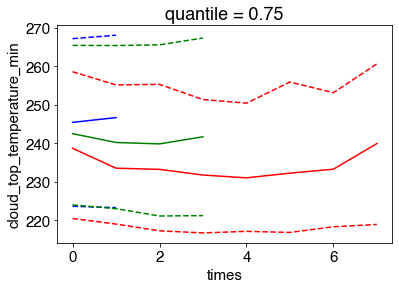

In [56]:
ctt_1_eSDC_pts.sel(quantile=0.5).plot(color='b')
ctt_1_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='b')
ctt_1_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='b')

ctt_2_eSDC_pts.sel(quantile=0.5).plot(color='g')
ctt_2_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='g')
ctt_2_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='g')

ctt_3_eSDC_pts.sel(quantile=0.5).plot(color='r')
ctt_3_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='r')
ctt_3_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='r')

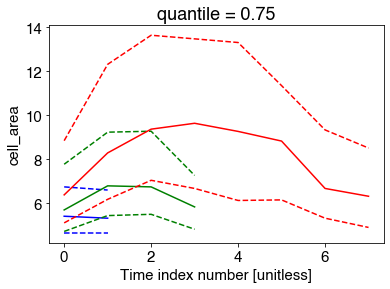

In [28]:
cell_diam1_eSDC_pts.sel(quantile=0.5).plot(color='b')
cell_diam1_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='b')
cell_diam1_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='b')

cell_diam2_eSDC_pts.sel(quantile=0.5).plot(color='g')
cell_diam2_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='g')
cell_diam2_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='g')

cell_diam3_eSDC_pts.sel(quantile=0.5).plot(color='r')
cell_diam3_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='r')
cell_diam3_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='r')

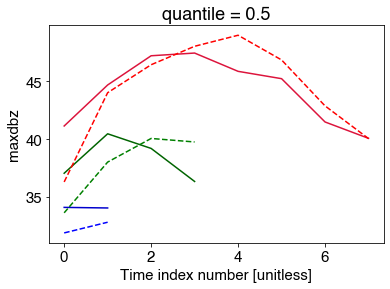

In [29]:
maxdbz1_eSDC_pts.sel(quantile=0.5).plot(color='mediumblue')
maxdbz1_wSDC_pts.sel(quantile=0.5).plot(ls='--', color='b')
# maxdbz1_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='b')
# maxdbz1_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='b')

maxdbz2_eSDC_pts.sel(quantile=0.5).plot(color='darkgreen')
maxdbz2_wSDC_pts.sel(quantile=0.5).plot(ls='--', color='green')

# maxdbz2_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='g')
# maxdbz2_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='g')

maxdbz3_eSDC_pts.sel(quantile=0.5).plot(color='crimson')
maxdbz3_wSDC_pts.sel(quantile=0.5).plot(ls='--', color='r')
# maxdbz3_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='r')
# maxdbz3_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='r')

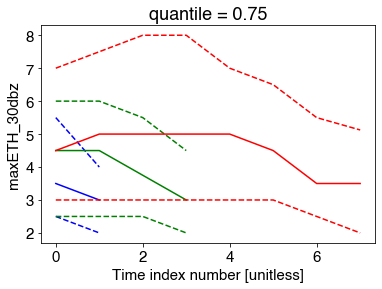

In [30]:
eth30_1_eSDC_pts.sel(quantile=0.5).plot(color='b')
eth30_1_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='b')
eth30_1_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='b')

eth30_2_eSDC_pts.sel(quantile=0.5).plot(color='g')
eth30_2_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='g')
eth30_2_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='g')

eth30_3_eSDC_pts.sel(quantile=0.5).plot(color='r')
eth30_3_eSDC_pts.sel(quantile=0.25).plot(ls='--', color='r')
eth30_3_eSDC_pts.sel(quantile=0.75).plot(ls='--', color='r')

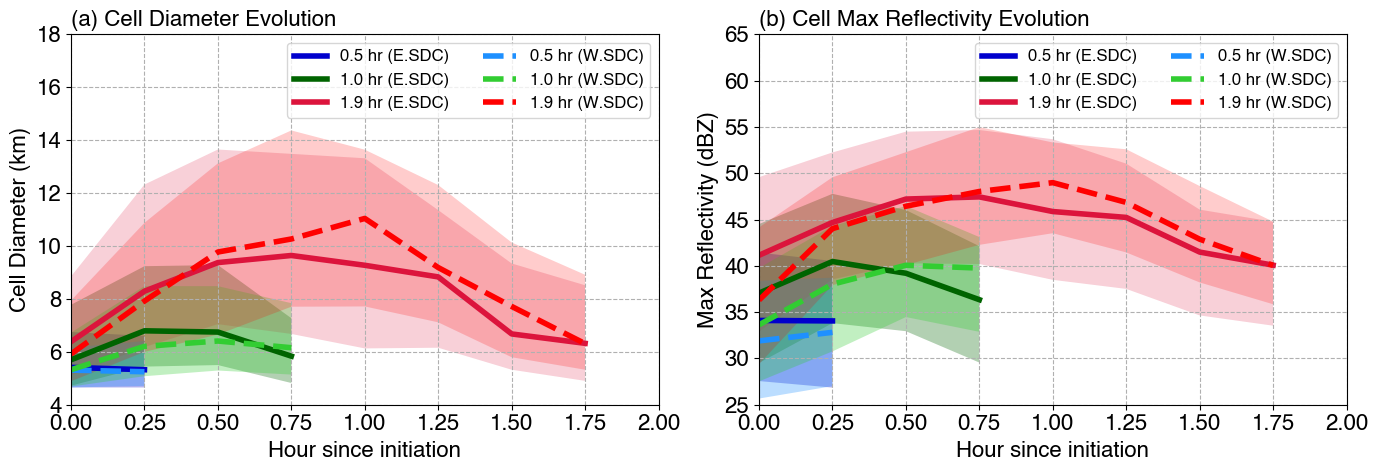

In [59]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

hours = times * time_res
colors_eSDC = {'short':'mediumblue', 'medium':'darkgreen', 'long':'crimson'}
colors_wSDC = {'short':'dodgerblue', 'medium':'limegreen', 'long':'red'}
xlims = [0,2]

# leg_day = f' ({LThour_day[0]} - {LThour_day[1]} LT)'
# leg_night = f' ({LThour_night[0]} - {LThour_night[1]} LT)'
leg_day = ''
leg_night = ''
# ax1.bar(lifetime_bins[:-1]+0.03, hist_eSDC, width=0.1, color='orangered', label=f'E.SDC{leg_day}')
# ax1.bar(lifetime_bins[:-1]-0.03, hist_wSDC, width=0.1, color='dodgerblue', label=f'W.SDC{leg_night}')

ax1 = axes[0]
ylims = [4,18]
# E.SDC
ax1.plot(hours, cell_diam1_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['short'], lw=4, label=f'{lifetime_range1[1]:.01f} hr (E.SDC{leg_day})')
ax1.plot(hours, cell_diam2_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['medium'], lw=4, label=f'{lifetime_range2[1]:.01f} hr (E.SDC{leg_day})')
ax1.plot(hours, cell_diam3_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['long'], lw=4, label=f'{np.mean(lifetime_range3):.01f} hr (E.SDC{leg_day})')
ax1.fill_between(hours, cell_diam1_eSDC_pts.sel(quantile=0.25), cell_diam1_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['short'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam2_eSDC_pts.sel(quantile=0.25), cell_diam2_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['medium'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam3_eSDC_pts.sel(quantile=0.25), cell_diam3_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['long'], edgecolor=None, alpha=0.2)
# W.SDC
ax1.plot(hours, cell_diam1_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['short'], lw=4, ls='--', label=f'{lifetime_range1[1]:.01f} hr (W.SDC{leg_night})')
ax1.plot(hours, cell_diam2_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['medium'], lw=4, ls='--', label=f'{lifetime_range2[1]:.01f} hr (W.SDC{leg_night})')
ax1.plot(hours, cell_diam3_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['long'], lw=4, ls='--', label=f'{np.mean(lifetime_range3):.01f} hr (W.SDC{leg_night})')
ax1.fill_between(hours, cell_diam1_wSDC_pts.sel(quantile=0.25), cell_diam1_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['short'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam2_wSDC_pts.sel(quantile=0.25), cell_diam2_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['medium'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam3_wSDC_pts.sel(quantile=0.25), cell_diam3_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['long'], edgecolor=None, alpha=0.2)
ax1.legend(ncol=2, fontsize=12)
ax1.set_xlabel('Hour since initiation')
ax1.set_ylabel('Cell Diameter (km)')
ax1.set_title('(a) Cell Diameter Evolution', loc='left', fontsize=16)
ax1.set_xlim(np.min(xlims), np.max(xlims))
ax1.set_ylim(np.min(ylims), np.max(ylims))
# ax1.set_yticks(yticks)
ax1.grid(ls='--')

ax2 = axes[1]
ylims = [25,65]
# E.SDC
ax2.plot(hours, maxdbz1_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['short'], lw=4, label=f'{lifetime_range1[1]:.01f} hr (E.SDC{leg_day})')
ax2.plot(hours, maxdbz2_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['medium'], lw=4, label=f'{lifetime_range2[1]:.01f} hr (E.SDC{leg_day})')
ax2.plot(hours, maxdbz3_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['long'], lw=4, label=f'{np.mean(lifetime_range3):.01f} hr (E.SDC{leg_day})')
ax2.fill_between(hours, maxdbz1_eSDC_pts.sel(quantile=0.25), maxdbz1_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['short'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, maxdbz2_eSDC_pts.sel(quantile=0.25), maxdbz2_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['medium'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, maxdbz3_eSDC_pts.sel(quantile=0.25), maxdbz3_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['long'], edgecolor=None, alpha=0.2)
# W.SDC
ax2.plot(hours, maxdbz1_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['short'], lw=4, ls='--', label=f'{lifetime_range1[1]:.01f} hr (W.SDC{leg_night})')
ax2.plot(hours, maxdbz2_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['medium'], lw=4, ls='--', label=f'{lifetime_range2[1]:.01f} hr (W.SDC{leg_night})')
ax2.plot(hours, maxdbz3_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['long'], lw=4, ls='--', label=f'{np.mean(lifetime_range3):.01f} hr (W.SDC{leg_night})')
ax2.fill_between(hours, maxdbz1_wSDC_pts.sel(quantile=0.25), maxdbz1_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['short'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, maxdbz2_wSDC_pts.sel(quantile=0.25), maxdbz2_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['medium'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, maxdbz3_wSDC_pts.sel(quantile=0.25), maxdbz3_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['long'], edgecolor=None, alpha=0.2)
ax2.legend(ncol=2, fontsize=12)
ax2.set_xlabel('Hour since initiation')
ax2.set_ylabel('Max Reflectivity (dBZ)')
ax2.set_title('(b) Cell Max Reflectivity Evolution', loc='left', fontsize=16)
ax2.set_xlim(np.min(xlims), np.max(xlims))
ax2.set_ylim(np.min(ylims), np.max(ylims))
# ax1.set_yticks(yticks)
ax2.grid(ls='--')

fig.tight_layout()
fig.savefig(f'{figdir}celltrack_composite_evolution_maxdiam_maxdbz_eSDC_wSDC.png', facecolor='w', bbox_inches='tight', dpi=300)

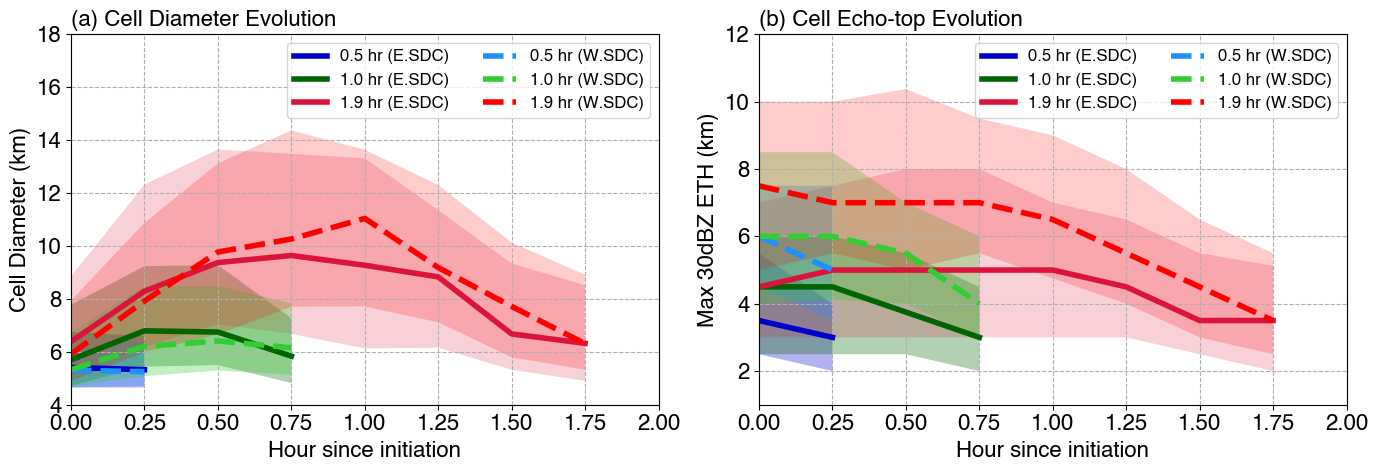

In [60]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

hours = times * time_res
colors_eSDC = {'short':'mediumblue', 'medium':'darkgreen', 'long':'crimson'}
colors_wSDC = {'short':'dodgerblue', 'medium':'limegreen', 'long':'red'}
xlims = [0,2]

# leg_day = f' ({LThour_day[0]} - {LThour_day[1]} LT)'
# leg_night = f' ({LThour_night[0]} - {LThour_night[1]} LT)'
leg_day = ''
leg_night = ''
# ax1.bar(lifetime_bins[:-1]+0.03, hist_eSDC, width=0.1, color='orangered', label=f'E.SDC ({LThour_day[0]} - {LThour_day[1]} LT)')
# ax1.bar(lifetime_bins[:-1]-0.03, hist_wSDC, width=0.1, color='dodgerblue', label=f'W.SDC ({LThour_night[0]} - {LThour_night[1]} LT)')

ax1 = axes[0]
ylims = [4,18]
# E.SDC
ax1.plot(hours, cell_diam1_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['short'], lw=4, label=f'{lifetime_range1[1]:.01f} hr (E.SDC{leg_day})')
ax1.plot(hours, cell_diam2_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['medium'], lw=4, label=f'{lifetime_range2[1]:.01f} hr (E.SDC{leg_day})')
ax1.plot(hours, cell_diam3_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['long'], lw=4, label=f'{np.mean(lifetime_range3):.01f} hr (E.SDC{leg_day})')
ax1.fill_between(hours, cell_diam1_eSDC_pts.sel(quantile=0.25), cell_diam1_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['short'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam2_eSDC_pts.sel(quantile=0.25), cell_diam2_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['medium'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam3_eSDC_pts.sel(quantile=0.25), cell_diam3_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['long'], edgecolor=None, alpha=0.2)
# W.SDC
ax1.plot(hours, cell_diam1_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['short'], lw=4, ls='--', label=f'{lifetime_range1[1]:.01f} hr (W.SDC{leg_night})')
ax1.plot(hours, cell_diam2_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['medium'], lw=4, ls='--', label=f'{lifetime_range2[1]:.01f} hr (W.SDC{leg_night})')
ax1.plot(hours, cell_diam3_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['long'], lw=4, ls='--', label=f'{np.mean(lifetime_range3):.01f} hr (W.SDC{leg_night})')
ax1.fill_between(hours, cell_diam1_wSDC_pts.sel(quantile=0.25), cell_diam1_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['short'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam2_wSDC_pts.sel(quantile=0.25), cell_diam2_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['medium'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam3_wSDC_pts.sel(quantile=0.25), cell_diam3_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['long'], edgecolor=None, alpha=0.2)
ax1.legend(ncol=2, fontsize=12)
ax1.set_xlabel('Hour since initiation')
ax1.set_ylabel('Cell Diameter (km)')
ax1.set_title('(a) Cell Diameter Evolution', loc='left', fontsize=16)
ax1.set_xlim(np.min(xlims), np.max(xlims))
ax1.set_ylim(np.min(ylims), np.max(ylims))
# ax1.set_yticks(yticks)
ax1.grid(ls='--')

ax2 = axes[1]
ylims = [1,12]
# E.SDC
ax2.plot(hours, eth30_1_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['short'], lw=4, label=f'{lifetime_range1[1]:.01f} hr (E.SDC{leg_day})')
ax2.plot(hours, eth30_2_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['medium'], lw=4, label=f'{lifetime_range2[1]:.01f} hr (E.SDC{leg_day})')
ax2.plot(hours, eth30_3_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['long'], lw=4, label=f'{np.mean(lifetime_range3):.01f} hr (E.SDC{leg_day})')
ax2.fill_between(hours, eth30_1_eSDC_pts.sel(quantile=0.25), eth30_1_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['short'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, eth30_2_eSDC_pts.sel(quantile=0.25), eth30_2_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['medium'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, eth30_3_eSDC_pts.sel(quantile=0.25), eth30_3_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['long'], edgecolor=None, alpha=0.2)
# W.SDC
ax2.plot(hours, eth30_1_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['short'], lw=4, ls='--', label=f'{lifetime_range1[1]:.01f} hr (W.SDC{leg_night})')
ax2.plot(hours, eth30_2_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['medium'], lw=4, ls='--', label=f'{lifetime_range2[1]:.01f} hr (W.SDC{leg_night})')
ax2.plot(hours, eth30_3_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['long'], lw=4, ls='--', label=f'{np.mean(lifetime_range3):.01f} hr (W.SDC{leg_night})')
ax2.fill_between(hours, eth30_1_wSDC_pts.sel(quantile=0.25), eth30_1_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['short'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, eth30_2_wSDC_pts.sel(quantile=0.25), eth30_2_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['medium'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, eth30_3_wSDC_pts.sel(quantile=0.25), eth30_3_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['long'], edgecolor=None, alpha=0.2)
ax2.legend(ncol=2, fontsize=12)
ax2.set_xlabel('Hour since initiation')
ax2.set_ylabel('Max 30dBZ ETH (km)')
ax2.set_title('(b) Cell Echo-top Evolution', loc='left', fontsize=16)
ax2.set_xlim(np.min(xlims), np.max(xlims))
ax2.set_ylim(np.min(ylims), np.max(ylims))
# ax1.set_yticks(yticks)
ax2.grid(ls='--')

fig.tight_layout()
fig.savefig(f'{figdir}celltrack_composite_evolution_maxdiam_maxETH30_eSDC_wSDC.png', facecolor='w', bbox_inches='tight', dpi=300)

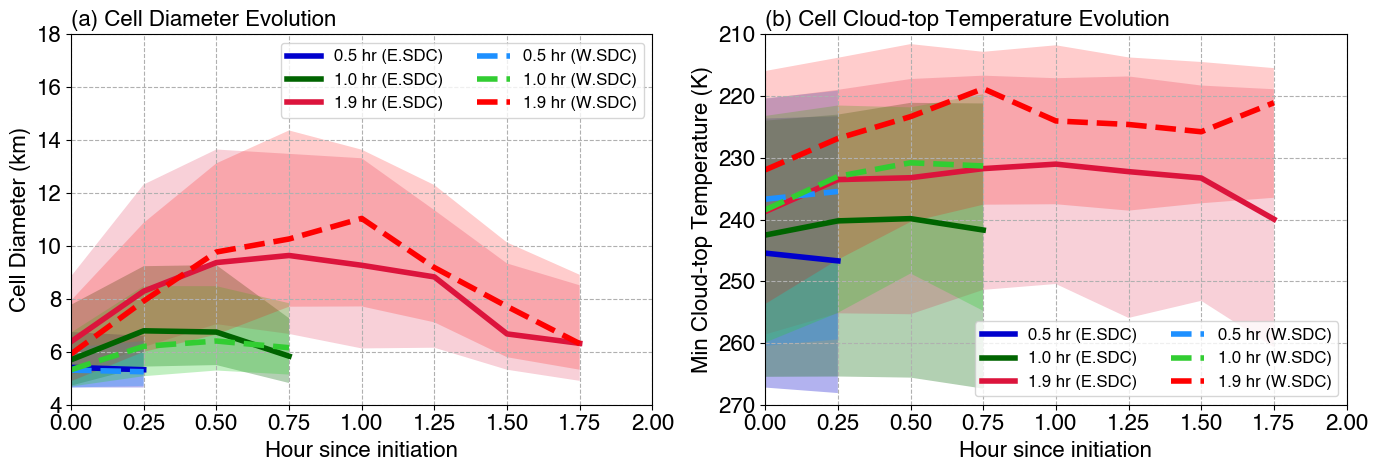

In [64]:
mpl.rcParams['font.size'] = 16
mpl.rcParams['font.family'] = 'Helvetica'
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

hours = times * time_res
colors_eSDC = {'short':'mediumblue', 'medium':'darkgreen', 'long':'crimson'}
colors_wSDC = {'short':'dodgerblue', 'medium':'limegreen', 'long':'red'}
xlims = [0,2]

# leg_day = f' ({LThour_day[0]} - {LThour_day[1]} LT)'
# leg_night = f' ({LThour_night[0]} - {LThour_night[1]} LT)'
leg_day = ''
leg_night = ''

ax1 = axes[0]
ylims = [4,18]
# E.SDC
ax1.plot(hours, cell_diam1_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['short'], lw=4, label=f'{lifetime_range1[1]:.01f} hr (E.SDC{leg_day})')
ax1.plot(hours, cell_diam2_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['medium'], lw=4, label=f'{lifetime_range2[1]:.01f} hr (E.SDC{leg_day})')
ax1.plot(hours, cell_diam3_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['long'], lw=4, label=f'{np.mean(lifetime_range3):.01f} hr (E.SDC{leg_day})')
ax1.fill_between(hours, cell_diam1_eSDC_pts.sel(quantile=0.25), cell_diam1_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['short'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam2_eSDC_pts.sel(quantile=0.25), cell_diam2_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['medium'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam3_eSDC_pts.sel(quantile=0.25), cell_diam3_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['long'], edgecolor=None, alpha=0.2)
# W.SDC
ax1.plot(hours, cell_diam1_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['short'], lw=4, ls='--', label=f'{lifetime_range1[1]:.01f} hr (W.SDC{leg_night})')
ax1.plot(hours, cell_diam2_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['medium'], lw=4, ls='--', label=f'{lifetime_range2[1]:.01f} hr (W.SDC{leg_night})')
ax1.plot(hours, cell_diam3_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['long'], lw=4, ls='--', label=f'{np.mean(lifetime_range3):.01f} hr (W.SDC{leg_night})')
ax1.fill_between(hours, cell_diam1_wSDC_pts.sel(quantile=0.25), cell_diam1_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['short'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam2_wSDC_pts.sel(quantile=0.25), cell_diam2_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['medium'], edgecolor=None, alpha=0.3)
ax1.fill_between(hours, cell_diam3_wSDC_pts.sel(quantile=0.25), cell_diam3_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['long'], edgecolor=None, alpha=0.2)
ax1.legend(ncol=2, fontsize=12)
ax1.set_xlabel('Hour since initiation')
ax1.set_ylabel('Cell Diameter (km)')
ax1.set_title('(a) Cell Diameter Evolution', loc='left', fontsize=16)
ax1.set_xlim(np.min(xlims), np.max(xlims))
ax1.set_ylim(np.min(ylims), np.max(ylims))
# ax1.set_yticks(yticks)
ax1.grid(ls='--')

ax2 = axes[1]
ylims = [270,210]
# E.SDC
ax2.plot(hours, ctt_1_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['short'], lw=4, label=f'{lifetime_range1[1]:.01f} hr (E.SDC{leg_day})')
ax2.plot(hours, ctt_2_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['medium'], lw=4, label=f'{lifetime_range2[1]:.01f} hr (E.SDC{leg_day})')
ax2.plot(hours, ctt_3_eSDC_pts.sel(quantile=0.5), color=colors_eSDC['long'], lw=4, label=f'{np.mean(lifetime_range3):.01f} hr (E.SDC{leg_day})')
ax2.fill_between(hours, ctt_1_eSDC_pts.sel(quantile=0.25), ctt_1_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['short'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, ctt_2_eSDC_pts.sel(quantile=0.25), ctt_2_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['medium'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, ctt_3_eSDC_pts.sel(quantile=0.25), ctt_3_eSDC_pts.sel(quantile=0.75), color=colors_eSDC['long'], edgecolor=None, alpha=0.2)
# W.SDC
ax2.plot(hours, ctt_1_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['short'], lw=4, ls='--', label=f'{lifetime_range1[1]:.01f} hr (W.SDC{leg_night})')
ax2.plot(hours, ctt_2_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['medium'], lw=4, ls='--', label=f'{lifetime_range2[1]:.01f} hr (W.SDC{leg_night})')
ax2.plot(hours, ctt_3_wSDC_pts.sel(quantile=0.5), color=colors_wSDC['long'], lw=4, ls='--', label=f'{np.mean(lifetime_range3):.01f} hr (W.SDC{leg_night})')
ax2.fill_between(hours, ctt_1_wSDC_pts.sel(quantile=0.25), ctt_1_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['short'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, ctt_2_wSDC_pts.sel(quantile=0.25), ctt_2_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['medium'], edgecolor=None, alpha=0.3)
ax2.fill_between(hours, ctt_3_wSDC_pts.sel(quantile=0.25), ctt_3_wSDC_pts.sel(quantile=0.75), color=colors_wSDC['long'], edgecolor=None, alpha=0.2)
ax2.legend(ncol=2, fontsize=12, loc='lower right')
ax2.set_xlabel('Hour since initiation')
ax2.set_ylabel('Min Cloud-top Temperature (K)')
ax2.set_title('(b) Cell Cloud-top Temperature Evolution', loc='left', fontsize=16)
ax2.set_xlim(np.min(xlims), np.max(xlims))
ax2.set_ylim(ylims[0], ylims[1])
# ax1.set_yticks(yticks)
ax2.grid(ls='--')

fig.tight_layout()
fig.savefig(f'{figdir}celltrack_composite_evolution_maxdiam_minctt_eSDC_wSDC.png', facecolor='w', bbox_inches='tight', dpi=300)

In [65]:
figdir

'/global/project/projectdirs/m1657/zfeng/cacti/arm/csapr/taranis_corcsapr2cfrppiqcM1_celltracking.c1.new/figures/celltrack_stats/'

In [25]:
quantiles = [0.5,0.75,0.9,0.95]
max_dbz1_eSDC = stats.max_reflectivity.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                        (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_dbz2_eSDC = stats.max_reflectivity.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                        (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_dbz3_eSDC = stats.max_reflectivity.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                        (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
# Replace NaN with a large negative value to take into account decreasing sample with height
# NaN is excluded in quantile calculations which biases the sampling with increasing height
fillval = -99
max_dbz1_eSDC = max_dbz1_eSDC.where(~np.isnan(max_dbz1_eSDC), other=fillval)
max_dbz2_eSDC = max_dbz2_eSDC.where(~np.isnan(max_dbz2_eSDC), other=fillval)
max_dbz3_eSDC = max_dbz3_eSDC.where(~np.isnan(max_dbz3_eSDC), other=fillval)
max_dbz_dur1_eSDC_pts = max_dbz1_eSDC.quantile(quantiles, dim='tracks', skipna=True)
max_dbz_dur2_eSDC_pts = max_dbz2_eSDC.quantile(quantiles, dim='tracks', skipna=True)
max_dbz_dur3_eSDC_pts = max_dbz3_eSDC.quantile(quantiles, dim='tracks', skipna=True)

In [26]:
max_dbz1_wSDC = stats.max_reflectivity.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                        (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_dbz2_wSDC = stats.max_reflectivity.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                        (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_dbz3_wSDC = stats.max_reflectivity.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                        (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
# Replace NaN with a large negative value to take into account decreasing sample with height
# NaN is excluded in quantile calculations which biases the sampling with increasing height
fillval = -99
max_dbz1_wSDC = max_dbz1_wSDC.where(~np.isnan(max_dbz1_wSDC), other=fillval)
max_dbz2_wSDC = max_dbz2_wSDC.where(~np.isnan(max_dbz2_wSDC), other=fillval)
max_dbz3_wSDC = max_dbz3_wSDC.where(~np.isnan(max_dbz3_wSDC), other=fillval)
max_dbz_dur1_wSDC_pts = max_dbz1_wSDC.quantile(quantiles, dim='tracks', skipna=True)
max_dbz_dur2_wSDC_pts = max_dbz2_wSDC.quantile(quantiles, dim='tracks', skipna=True)
max_dbz_dur3_wSDC_pts = max_dbz3_wSDC.quantile(quantiles, dim='tracks', skipna=True)

In [27]:
dbz20_diam1_eSDC = 2 * np.sqrt(stats.npix_dbz20.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                                 (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz20_diam2_eSDC = 2 * np.sqrt(stats.npix_dbz20.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                                 (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz20_diam3_eSDC = 2 * np.sqrt(stats.npix_dbz20.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                                 (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
fillval = -99
dbz20_diam1_eSDC = dbz20_diam1_eSDC.where(~np.isnan(dbz20_diam1_eSDC), other=fillval)
dbz20_diam2_eSDC = dbz20_diam2_eSDC.where(~np.isnan(dbz20_diam2_eSDC), other=fillval)
dbz20_diam3_eSDC = dbz20_diam3_eSDC.where(~np.isnan(dbz20_diam3_eSDC), other=fillval)
dbz20_diam1_eSDC_pts = dbz20_diam1_eSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz20_diam2_eSDC_pts = dbz20_diam2_eSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz20_diam3_eSDC_pts = dbz20_diam3_eSDC.quantile(quantiles, dim='tracks', skipna=True)

In [28]:
dbz20_diam1_wSDC = 2 * np.sqrt(stats.npix_dbz20.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                                 (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz20_diam2_wSDC = 2 * np.sqrt(stats.npix_dbz20.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                                 (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz20_diam3_wSDC = 2 * np.sqrt(stats.npix_dbz20.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                                 (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
fillval = -99
dbz20_diam1_wSDC = dbz20_diam1_wSDC.where(~np.isnan(dbz20_diam1_wSDC), other=fillval)
dbz20_diam2_wSDC = dbz20_diam2_wSDC.where(~np.isnan(dbz20_diam2_wSDC), other=fillval)
dbz20_diam3_wSDC = dbz20_diam3_wSDC.where(~np.isnan(dbz20_diam3_wSDC), other=fillval)
dbz20_diam1_wSDC_pts = dbz20_diam1_wSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz20_diam2_wSDC_pts = dbz20_diam2_wSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz20_diam3_wSDC_pts = dbz20_diam3_wSDC.quantile(quantiles, dim='tracks', skipna=True)

In [29]:
dbz30_diam1_eSDC = 2 * np.sqrt(stats.npix_dbz30.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                                 (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz30_diam2_eSDC = 2 * np.sqrt(stats.npix_dbz30.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                                 (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz30_diam3_eSDC = 2 * np.sqrt(stats.npix_dbz30.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                                 (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
fillval = -99
dbz30_diam1_eSDC = dbz30_diam1_eSDC.where(~np.isnan(dbz30_diam1_eSDC), other=fillval)
dbz30_diam2_eSDC = dbz30_diam2_eSDC.where(~np.isnan(dbz30_diam2_eSDC), other=fillval)
dbz30_diam3_eSDC = dbz30_diam3_eSDC.where(~np.isnan(dbz30_diam3_eSDC), other=fillval)
dbz30_diam1_eSDC_pts = dbz30_diam1_eSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz30_diam2_eSDC_pts = dbz30_diam2_eSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz30_diam3_eSDC_pts = dbz30_diam3_eSDC.quantile(quantiles, dim='tracks', skipna=True)

In [30]:
dbz30_diam1_wSDC = 2 * np.sqrt(stats.npix_dbz30.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                                 (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz30_diam2_wSDC = 2 * np.sqrt(stats.npix_dbz30.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                                 (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz30_diam3_wSDC = 2 * np.sqrt(stats.npix_dbz30.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                                 (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
fillval = -99
dbz30_diam1_wSDC = dbz30_diam1_wSDC.where(~np.isnan(dbz30_diam1_wSDC), other=fillval)
dbz30_diam2_wSDC = dbz30_diam2_wSDC.where(~np.isnan(dbz30_diam2_wSDC), other=fillval)
dbz30_diam3_wSDC = dbz30_diam3_wSDC.where(~np.isnan(dbz30_diam3_wSDC), other=fillval)
dbz30_diam1_wSDC_pts = dbz30_diam1_wSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz30_diam2_wSDC_pts = dbz30_diam2_wSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz30_diam3_wSDC_pts = dbz30_diam3_wSDC.quantile(quantiles, dim='tracks', skipna=True)

In [31]:
dbz40_diam1_eSDC = 2 * np.sqrt(stats.npix_dbz40.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                                      (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz40_diam2_eSDC = 2 * np.sqrt(stats.npix_dbz40.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                                      (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz40_diam3_eSDC = 2 * np.sqrt(stats.npix_dbz40.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                                      (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
fillval = -99
dbz40_diam1_eSDC = dbz40_diam1_eSDC.where(~np.isnan(dbz40_diam1_eSDC), other=fillval)
dbz40_diam2_eSDC = dbz40_diam2_eSDC.where(~np.isnan(dbz40_diam2_eSDC), other=fillval)
dbz40_diam3_eSDC = dbz40_diam3_eSDC.where(~np.isnan(dbz40_diam3_eSDC), other=fillval)
dbz40_diam1_eSDC_pts = dbz40_diam1_eSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz40_diam2_eSDC_pts = dbz40_diam2_eSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz40_diam3_eSDC_pts = dbz40_diam3_eSDC.quantile(quantiles, dim='tracks', skipna=True)

In [32]:
dbz40_diam1_wSDC = 2 * np.sqrt(stats.npix_dbz40.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                                      (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz40_diam2_wSDC = 2 * np.sqrt(stats.npix_dbz40.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                                      (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
dbz40_diam3_wSDC = 2 * np.sqrt(stats.npix_dbz40.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                                      (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True) * pixel_radius**2 / np.pi)
fillval = -99
dbz40_diam1_wSDC = dbz40_diam1_wSDC.where(~np.isnan(dbz40_diam1_wSDC), other=fillval)
dbz40_diam2_wSDC = dbz40_diam2_wSDC.where(~np.isnan(dbz40_diam2_wSDC), other=fillval)
dbz40_diam3_wSDC = dbz40_diam3_wSDC.where(~np.isnan(dbz40_diam3_wSDC), other=fillval)
dbz40_diam1_wSDC_pts = dbz40_diam1_wSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz40_diam2_wSDC_pts = dbz40_diam2_wSDC.quantile(quantiles, dim='tracks', skipna=True)
dbz40_diam3_wSDC_pts = dbz40_diam3_wSDC.quantile(quantiles, dim='tracks', skipna=True)

In [33]:
max_zdr1_eSDC = stats.max_zdr.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                    (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_zdr2_eSDC = stats.max_zdr.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                    (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_zdr3_eSDC = stats.max_zdr.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                    (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_zdr1_eSDC = max_zdr1_eSDC.where(~np.isnan(max_zdr1_eSDC), other=fillval)
max_zdr2_eSDC = max_zdr2_eSDC.where(~np.isnan(max_zdr2_eSDC), other=fillval)
max_zdr3_eSDC = max_zdr3_eSDC.where(~np.isnan(max_zdr3_eSDC), other=fillval)
max_zdr1_eSDC_pts = max_zdr1_eSDC.quantile(quantiles, dim='tracks', skipna=True)
max_zdr2_eSDC_pts = max_zdr2_eSDC.quantile(quantiles, dim='tracks', skipna=True)
max_zdr3_eSDC_pts = max_zdr3_eSDC.quantile(quantiles, dim='tracks', skipna=True)

In [34]:
max_zdr1_wSDC = stats.max_zdr.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                    (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_zdr2_wSDC = stats.max_zdr.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                    (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_zdr3_wSDC = stats.max_zdr.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                    (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_zdr1_wSDC = max_zdr1_wSDC.where(~np.isnan(max_zdr1_wSDC), other=fillval)
max_zdr2_wSDC = max_zdr2_wSDC.where(~np.isnan(max_zdr2_wSDC), other=fillval)
max_zdr3_wSDC = max_zdr3_wSDC.where(~np.isnan(max_zdr3_wSDC), other=fillval)
max_zdr1_wSDC_pts = max_zdr1_wSDC.quantile(quantiles, dim='tracks', skipna=True)
max_zdr2_wSDC_pts = max_zdr2_wSDC.quantile(quantiles, dim='tracks', skipna=True)
max_zdr3_wSDC_pts = max_zdr3_wSDC.quantile(quantiles, dim='tracks', skipna=True)

In [35]:
max_kdp1_eSDC = stats.max_kdp.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                    (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_kdp2_eSDC = stats.max_kdp.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                    (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_kdp3_eSDC = stats.max_kdp.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                    (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_kdp1_eSDC = max_kdp1_eSDC.where(~np.isnan(max_kdp1_eSDC), other=fillval)
max_kdp2_eSDC = max_kdp2_eSDC.where(~np.isnan(max_kdp2_eSDC), other=fillval)
max_kdp3_eSDC = max_kdp3_eSDC.where(~np.isnan(max_kdp3_eSDC), other=fillval)
max_kdp1_eSDC_pts = max_kdp1_eSDC.quantile(quantiles, dim='tracks', skipna=True)
max_kdp2_eSDC_pts = max_kdp2_eSDC.quantile(quantiles, dim='tracks', skipna=True)
max_kdp3_eSDC_pts = max_kdp3_eSDC.quantile(quantiles, dim='tracks', skipna=True)

In [36]:
max_kdp1_wSDC = stats.max_kdp.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                    (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_kdp2_wSDC = stats.max_kdp.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                    (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_kdp3_wSDC = stats.max_kdp.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                    (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_kdp1_wSDC = max_kdp1_wSDC.where(~np.isnan(max_kdp1_wSDC), other=fillval)
max_kdp2_wSDC = max_kdp2_wSDC.where(~np.isnan(max_kdp2_wSDC), other=fillval)
max_kdp3_wSDC = max_kdp3_wSDC.where(~np.isnan(max_kdp3_wSDC), other=fillval)
max_kdp1_wSDC_pts = max_kdp1_wSDC.quantile(quantiles, dim='tracks', skipna=True)
max_kdp2_wSDC_pts = max_kdp2_wSDC.quantile(quantiles, dim='tracks', skipna=True)
max_kdp3_wSDC_pts = max_kdp3_wSDC.quantile(quantiles, dim='tracks', skipna=True)

In [37]:
max_rainrate1_eSDC = stats.max_rainrate.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                              (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_rainrate2_eSDC = stats.max_rainrate.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                              (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_rainrate3_eSDC = stats.max_rainrate.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                              (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_rainrate1_eSDC = max_rainrate1_eSDC.where(~np.isnan(max_rainrate1_eSDC), other=fillval)
max_rainrate2_eSDC = max_rainrate2_eSDC.where(~np.isnan(max_rainrate2_eSDC), other=fillval)
max_rainrate3_eSDC = max_rainrate3_eSDC.where(~np.isnan(max_rainrate3_eSDC), other=fillval)
max_rainrate1_eSDC_pts = max_rainrate1_eSDC.quantile(quantiles, dim='tracks', skipna=True)
max_rainrate2_eSDC_pts = max_rainrate2_eSDC.quantile(quantiles, dim='tracks', skipna=True)
max_rainrate3_eSDC_pts = max_rainrate3_eSDC.quantile(quantiles, dim='tracks', skipna=True)

In [38]:
max_rainrate1_wSDC = stats.max_rainrate.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                              (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_rainrate2_wSDC = stats.max_rainrate.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                              (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_rainrate3_wSDC = stats.max_rainrate.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                              (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_rainrate1_wSDC = max_rainrate1_wSDC.where(~np.isnan(max_rainrate1_wSDC), other=fillval)
max_rainrate2_wSDC = max_rainrate2_wSDC.where(~np.isnan(max_rainrate2_wSDC), other=fillval)
max_rainrate3_wSDC = max_rainrate3_wSDC.where(~np.isnan(max_rainrate3_wSDC), other=fillval)
max_rainrate1_wSDC_pts = max_rainrate1_wSDC.quantile(quantiles, dim='tracks', skipna=True)
max_rainrate2_wSDC_pts = max_rainrate2_wSDC.quantile(quantiles, dim='tracks', skipna=True)
max_rainrate3_wSDC_pts = max_rainrate3_wSDC.quantile(quantiles, dim='tracks', skipna=True)

In [39]:
max_Dm1_eSDC = stats.max_Dm.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                  (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_Dm2_eSDC = stats.max_Dm.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                  (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_Dm3_eSDC = stats.max_Dm.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                  (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_Dm1_eSDC = max_Dm1_eSDC.where(~np.isnan(max_Dm1_eSDC), other=fillval)
max_Dm2_eSDC = max_Dm2_eSDC.where(~np.isnan(max_Dm2_eSDC), other=fillval)
max_Dm3_eSDC = max_Dm3_eSDC.where(~np.isnan(max_Dm3_eSDC), other=fillval)
max_Dm1_eSDC_pts = max_Dm1_eSDC.quantile(quantiles, dim='tracks', skipna=True)
max_Dm2_eSDC_pts = max_Dm2_eSDC.quantile(quantiles, dim='tracks', skipna=True)
max_Dm3_eSDC_pts = max_Dm3_eSDC.quantile(quantiles, dim='tracks', skipna=True)

In [40]:
max_Dm1_wSDC = stats.max_Dm.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                  (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_Dm2_wSDC = stats.max_Dm.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                  (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
max_Dm3_wSDC = stats.max_Dm.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                  (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
max_Dm1_wSDC = max_Dm1_wSDC.where(~np.isnan(max_Dm1_wSDC), other=fillval)
max_Dm2_wSDC = max_Dm2_wSDC.where(~np.isnan(max_Dm2_wSDC), other=fillval)
max_Dm3_wSDC = max_Dm3_wSDC.where(~np.isnan(max_Dm3_wSDC), other=fillval)
max_Dm1_wSDC_pts = max_Dm1_wSDC.quantile(quantiles, dim='tracks', skipna=True)
max_Dm2_wSDC_pts = max_Dm2_wSDC.quantile(quantiles, dim='tracks', skipna=True)
max_Dm3_wSDC_pts = max_Dm3_wSDC.quantile(quantiles, dim='tracks', skipna=True)

In [41]:
volrain1_eSDC = stats.volrain.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                    (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
volrain2_eSDC = stats.volrain.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                    (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
volrain3_eSDC = stats.volrain.where((start_hour >= UTChour_day[0]) & (start_hour <= UTChour_day[1]) & (start_lon >= lon_SDC) & 
                                    (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
volrain1_eSDC = volrain1_eSDC.where(~np.isnan(volrain1_eSDC), other=fillval)
volrain2_eSDC = volrain2_eSDC.where(~np.isnan(volrain2_eSDC), other=fillval)
volrain3_eSDC = volrain3_eSDC.where(~np.isnan(volrain3_eSDC), other=fillval)
volrain1_eSDC_pts = volrain1_eSDC.quantile(quantiles, dim='tracks', skipna=True)
volrain2_eSDC_pts = volrain2_eSDC.quantile(quantiles, dim='tracks', skipna=True)
volrain3_eSDC_pts = volrain3_eSDC.quantile(quantiles, dim='tracks', skipna=True)

In [42]:
volrain1_wSDC = stats.volrain.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                    (lifetime > lifetime_range1[0]) & (lifetime <= lifetime_range1[1]) & np.isnan(end_merge_tracknumber), drop=True)
volrain2_wSDC = stats.volrain.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                    (lifetime > lifetime_range2[0]) & (lifetime <= lifetime_range2[1]) & np.isnan(end_merge_tracknumber), drop=True)
volrain3_wSDC = stats.volrain.where((start_hour >= UTChour_night[0]) & (start_hour <= UTChour_night[1]) & (start_lon < lon_SDC) & 
                                    (lifetime > lifetime_range3[0]) & (lifetime <= lifetime_range3[1]) & np.isnan(end_merge_tracknumber), drop=True)
fillval = -99
volrain1_wSDC = volrain1_wSDC.where(~np.isnan(volrain1_wSDC), other=fillval)
volrain2_wSDC = volrain2_wSDC.where(~np.isnan(volrain2_wSDC), other=fillval)
volrain3_wSDC = volrain3_wSDC.where(~np.isnan(volrain3_wSDC), other=fillval)
volrain1_wSDC_pts = volrain1_wSDC.quantile(quantiles, dim='tracks', skipna=True)
volrain2_wSDC_pts = volrain2_wSDC.quantile(quantiles, dim='tracks', skipna=True)
volrain3_wSDC_pts = volrain3_wSDC.quantile(quantiles, dim='tracks', skipna=True)

In [43]:
# dbz30_diam3_eSDC_pts.sel(quantile=qntl).isel(times=slice(0,20)).transpose().plot(vmin=0, cmap='gist_ncar')

In [44]:
# max_zdr3_eSDC_pts.sel(quantile=qntl).isel(times=slice(0,20)).transpose().plot(vmin=0, cmap='gist_ncar')

In [45]:
def plot_timeheight_3panel(times, heights, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, quantile, legend, figname, oob_colors=None):
# def plot_timeheight_3panel(times, heights, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, quantile, figname):

    mpl.rcParams['font.size'] = 15
    mpl.rcParams['font.family'] = 'Helvetica'
    mpl.rcParams['figure.facecolor'] = 'white'
    fig, axs = plt.subplots(1, 3, figsize=[15,4], dpi=100)

    cmap = copy.copy(plt.get_cmap(cmap))
    norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=cmap.N)
    xlabels = 'Hour since initiation'
    ylabels = ['Height (km)','','']

    pcm_save = []
    for col in range(3):
        ax1 = axs[col]
        Zm = np.ma.masked_invalid(dataarr[col])
        Zm = np.ma.masked_where(Zm <= 0, Zm)
        pcm = ax1.pcolormesh(times, heights, Zm, shading='auto', norm=norm, cmap=cmap)
        ax1.set_xlabel(xlabels)
        ax1.set_ylabel(ylabels[col])
        ax1.set_title(titles[col], loc='left', fontsize=16)
        ax1.set_title(f'{quantile:.0f}'+'$^{th}$ percentile', loc='right', fontsize=12)
        ax1.set_xlim(np.min(xlims), np.max(xlims))
        ax1.set_ylim(np.min(ylims), np.max(ylims))
        ax1.set_yticks(yticks)
        ax1.grid(ls='--')
        ax1.text(.98, .9, legend[col], ha='right', transform=ax1.transAxes)
        if oob_colors is not None:
            pcm.cmap.set_over(oob_colors['over'])
            pcm.cmap.set_under(oob_colors['under'])
            pcm.set_clim(min(levels), max(levels))
    # Save pcolormesh object for plotting colorbar
    pcm_save.append(pcm)

    # Adjust the layout before plotting colorbar
    fig.tight_layout()

    # Colorbar
    cbar = fig.colorbar(pcm_save[0], ax=axs[:], shrink=1, pad=0.02, label=cblabel, extend='both')
    cbar.set_ticks(cbticks)

    fig.savefig(figname, bbox_inches='tight', dpi=300)

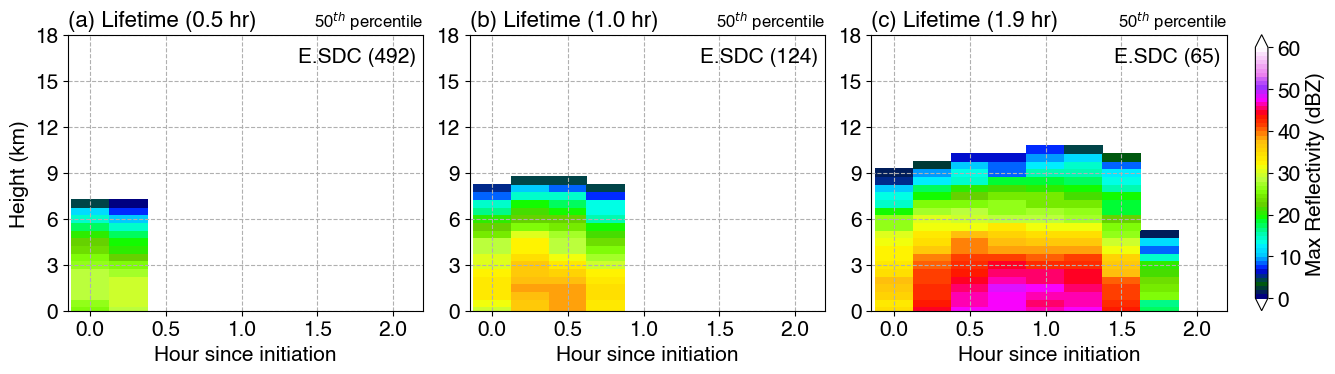

In [46]:
times_hour = times * time_res
legend = [f'E.SDC ({ntracks1_eSDC})', f'E.SDC ({ntracks2_eSDC})', f'E.SDC ({ntracks3_eSDC})',]
qntl = 0.5
dataarr = [max_dbz_dur1_eSDC_pts.sel(quantile=qntl).transpose(), max_dbz_dur2_eSDC_pts.sel(quantile=qntl).transpose(), max_dbz_dur3_eSDC_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 60.1, 1)
cbticks = np.arange(0, 60.1, 10)
cmap = 'gist_ncar'
xlims = (-0.15,2.2)
ylims = (0,18)
yticks = np.arange(0,18.1,3)
# titles = [f'(a) Lifetime ({lifetime_range1[0]}-{lifetime_range1[1]} hr)', 
#           f'(b) Lifetime ({lifetime_range2[0]}-{lifetime_range2[1]} hr)', 
#           f'(c) Lifetime ({lifetime_range3[0]}-{lifetime_range3[1]} hr)']
titles = [f'(a) Lifetime ({lifetime_range1[1]:.01f} hr)', 
          f'(b) Lifetime ({lifetime_range2[1]:.01f} hr)', 
          f'(c) Lifetime ({np.mean(lifetime_range3):.01f} hr)']
cblabel = 'Max Reflectivity (dBZ)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxdbz_{qntl*100:.0f}quantile_eSDC.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

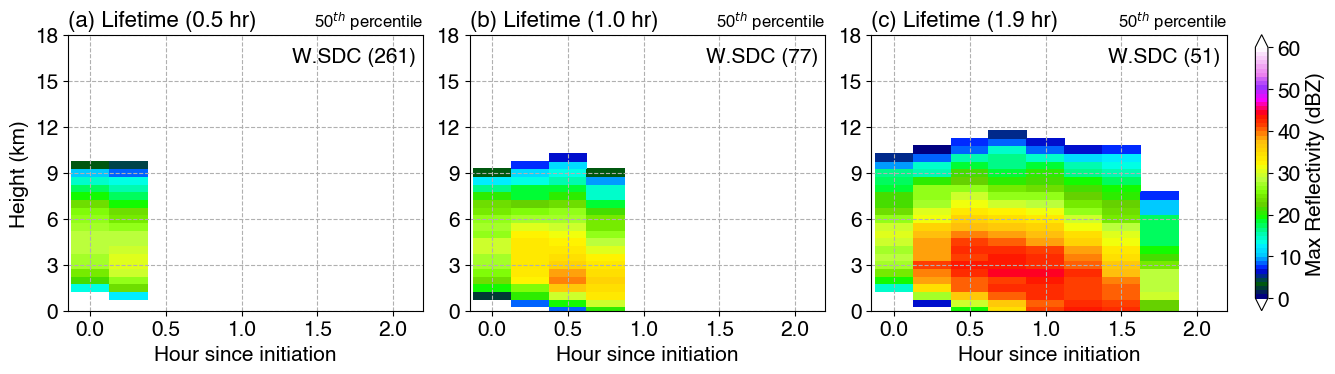

In [47]:
legend = [f'W.SDC ({ntracks1_wSDC})', f'W.SDC ({ntracks2_wSDC})', f'W.SDC ({ntracks3_wSDC})']
qntl = 0.5
dataarr = [max_dbz_dur1_wSDC_pts.sel(quantile=qntl).transpose(), max_dbz_dur2_wSDC_pts.sel(quantile=qntl).transpose(), max_dbz_dur3_wSDC_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 60.1, 1)
cbticks = np.arange(0, 60.1, 10)
cmap = 'gist_ncar'
xlims = (-0.15,2.2)
ylims = (0,18)
yticks = np.arange(0,18.1,3)
titles = [f'(a) Lifetime ({lifetime_range1[1]:.01f} hr)', 
          f'(b) Lifetime ({lifetime_range2[1]:.01f} hr)', 
          f'(c) Lifetime ({np.mean(lifetime_range3):.01f} hr)']
cblabel = 'Max Reflectivity (dBZ)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxdbz_{qntl*100:.0f}quantile_wSDC.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

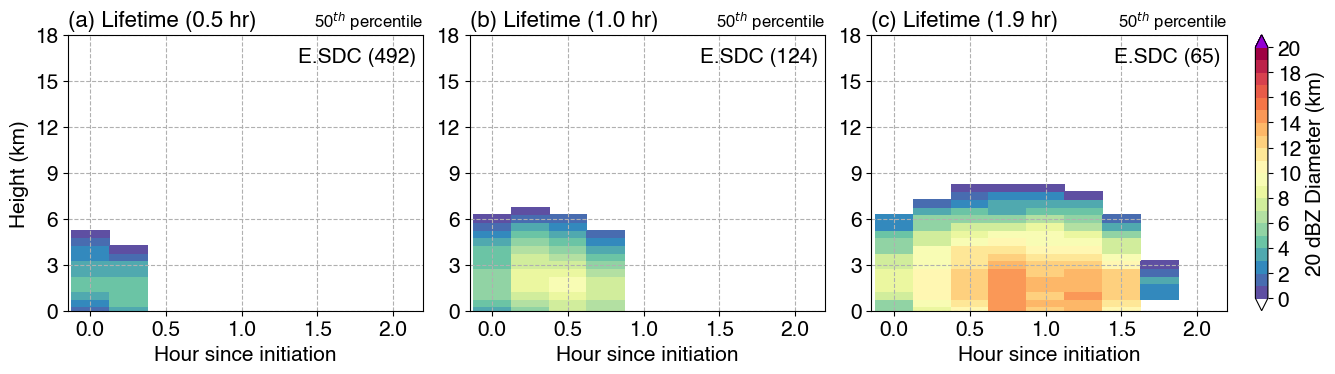

In [48]:
qntl = 0.5
legend = [f'E.SDC ({ntracks1_eSDC})', f'E.SDC ({ntracks2_eSDC})', f'E.SDC ({ntracks3_eSDC})']
dataarr = [dbz20_diam1_eSDC_pts.sel(quantile=qntl).transpose(), dbz20_diam2_eSDC_pts.sel(quantile=qntl).transpose(), dbz20_diam3_eSDC_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 20.1, 1)
cbticks = np.arange(0, 20.1, 2)
cmap = 'Spectral_r'
cblabel = '20 dBZ Diameter (km)'
figname = f'{figdir}celltrack_composite_profile_evolution_diameter20dbz_{qntl*100:.0f}quantile_eSDC.png'
oob_colors = {'over':'darkviolet', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

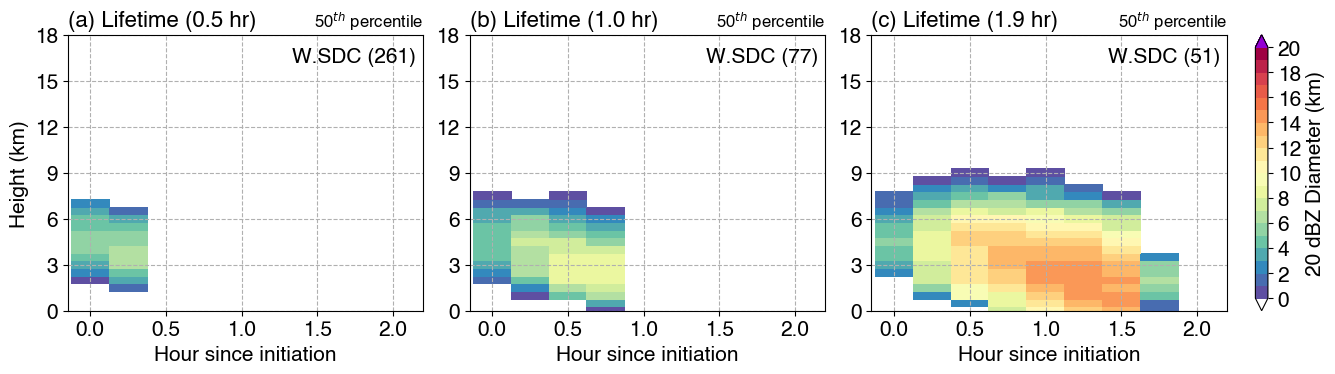

In [49]:
qntl = 0.5
legend = [f'W.SDC ({ntracks1_wSDC})', f'W.SDC ({ntracks2_wSDC})', f'W.SDC ({ntracks3_wSDC})']
dataarr = [dbz20_diam1_wSDC_pts.sel(quantile=qntl).transpose(), dbz20_diam2_wSDC_pts.sel(quantile=qntl).transpose(), dbz20_diam3_wSDC_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 20.1, 1)
cbticks = np.arange(0, 20.1, 2)
cmap = 'Spectral_r'
cblabel = '20 dBZ Diameter (km)'
figname = f'{figdir}celltrack_composite_profile_evolution_diameter20dbz_{qntl*100:.0f}quantile_wSDC.png'
oob_colors = {'over':'darkviolet', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

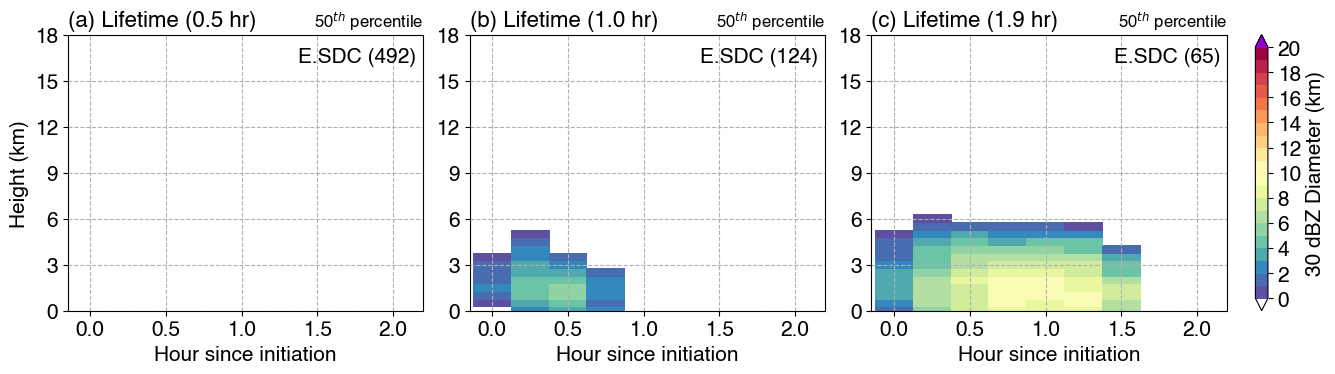

In [50]:
qntl = 0.5
legend = [f'E.SDC ({ntracks1_eSDC})', f'E.SDC ({ntracks2_eSDC})', f'E.SDC ({ntracks3_eSDC})']
dataarr = [dbz30_diam1_eSDC_pts.sel(quantile=qntl).transpose(), dbz30_diam2_eSDC_pts.sel(quantile=qntl).transpose(), dbz30_diam3_eSDC_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 20.1, 1)
cbticks = np.arange(0, 20.1, 2)
cmap = 'Spectral_r'
cblabel = '30 dBZ Diameter (km)'
figname = f'{figdir}celltrack_composite_profile_evolution_diameter30dbz_{qntl*100:.0f}quantile_eSDC.png'
oob_colors = {'over':'darkviolet', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

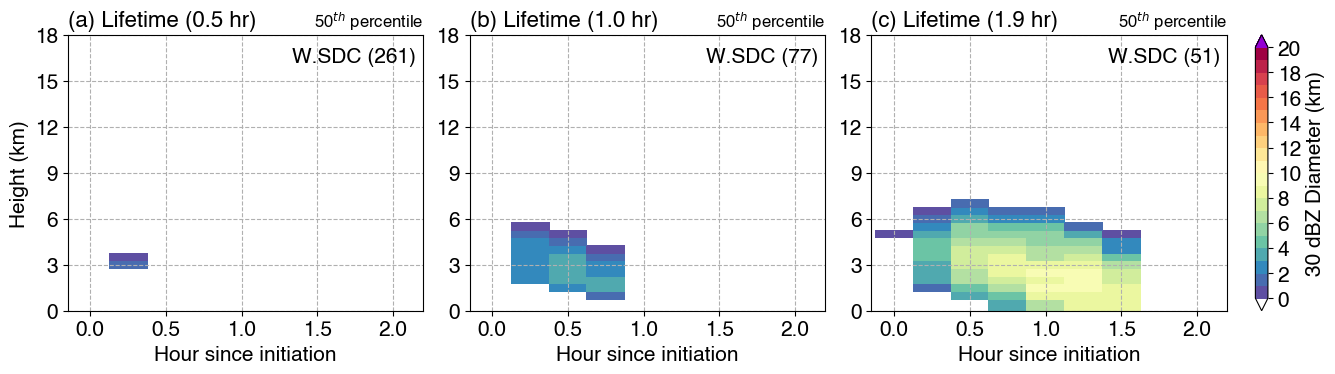

In [51]:
qntl = 0.5
legend = [f'W.SDC ({ntracks1_wSDC})', f'W.SDC ({ntracks2_wSDC})', f'W.SDC ({ntracks3_wSDC})']
dataarr = [dbz30_diam1_wSDC_pts.sel(quantile=qntl).transpose(), dbz30_diam2_wSDC_pts.sel(quantile=qntl).transpose(), dbz30_diam3_wSDC_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 20.1, 1)
cbticks = np.arange(0, 20.1, 2)
cmap = 'Spectral_r'
cblabel = '30 dBZ Diameter (km)'
figname = f'{figdir}celltrack_composite_profile_evolution_diameter30dbz_{qntl*100:.0f}quantile_wSDC.png'
oob_colors = {'over':'darkviolet', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

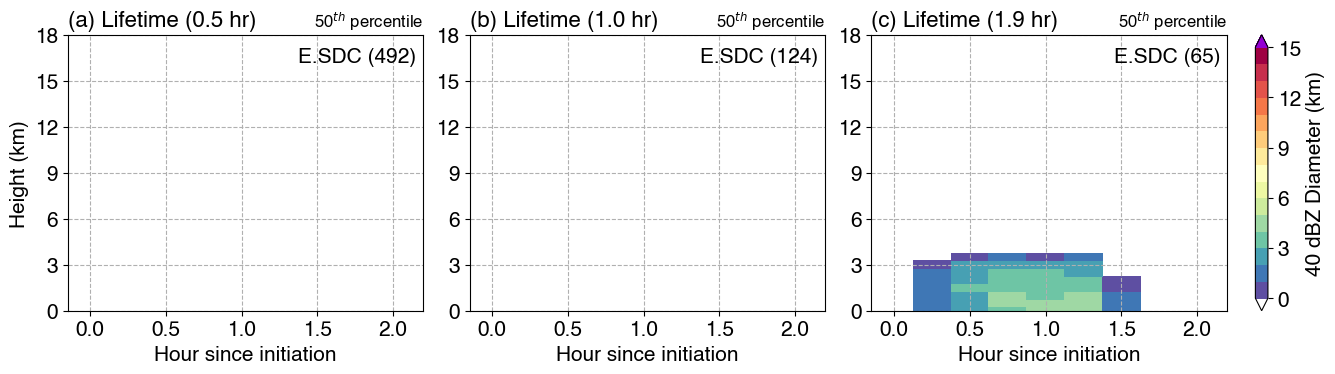

In [52]:
qntl = 0.5
legend = [f'E.SDC ({ntracks1_eSDC})', f'E.SDC ({ntracks2_eSDC})', f'E.SDC ({ntracks3_eSDC})']
dataarr = [dbz40_diam1_eSDC_pts.sel(quantile=qntl).transpose(), dbz40_diam2_eSDC_pts.sel(quantile=qntl).transpose(), dbz40_diam3_eSDC_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 15.1, 1)
cbticks = np.arange(0, 15.1, 3)
cmap = 'Spectral_r'
cblabel = '40 dBZ Diameter (km)'
figname = f'{figdir}celltrack_composite_profile_evolution_diameter40dbz_{qntl*100:.0f}quantile_eSDC.png'
oob_colors = {'over':'darkviolet', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

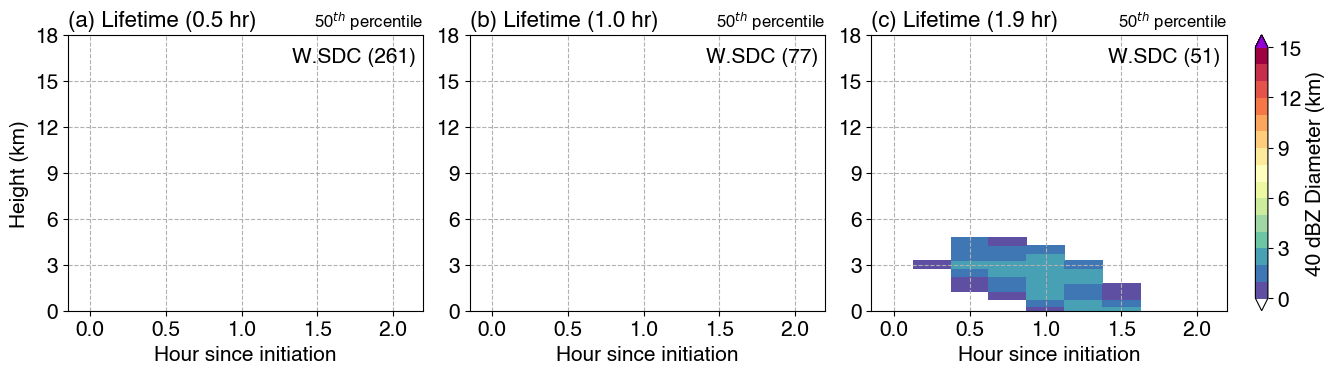

In [53]:
qntl = 0.5
legend = [f'W.SDC ({ntracks1_wSDC})', f'W.SDC ({ntracks2_wSDC})', f'W.SDC ({ntracks3_wSDC})']
dataarr = [dbz40_diam1_wSDC_pts.sel(quantile=qntl).transpose(), dbz40_diam2_wSDC_pts.sel(quantile=qntl).transpose(), dbz40_diam3_wSDC_pts.sel(quantile=qntl).transpose()]
levels = np.arange(0, 15.1, 1)
cbticks = np.arange(0, 15.1, 3)
cmap = 'Spectral_r'
cblabel = '40 dBZ Diameter (km)'
figname = f'{figdir}celltrack_composite_profile_evolution_diameter40dbz_{qntl*100:.0f}quantile_wSDC.png'
oob_colors = {'over':'darkviolet', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

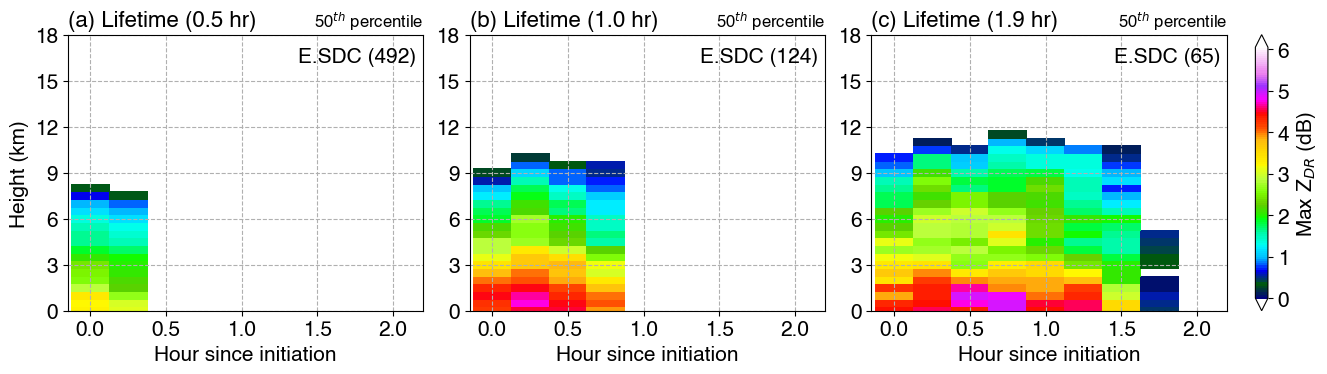

In [54]:
qntl = 0.5
legend = [f'E.SDC ({ntracks1_eSDC})', f'E.SDC ({ntracks2_eSDC})', f'E.SDC ({ntracks3_eSDC})']
dataarr = [max_zdr1_eSDC_pts.sel(quantile=qntl).transpose(), max_zdr2_eSDC_pts.sel(quantile=qntl).transpose(), max_zdr3_eSDC_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(1, 10.1, 0.1)
# cbticks = np.arange(1, 10.1, 1)
levels = np.arange(0, 6.1, 0.05)
cbticks = np.arange(0, 6.1, 1)
cmap = 'gist_ncar'
cblabel = 'Max Z$_{DR}$ (dB)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxzdr_{qntl*100:.0f}quantile_eSDC.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

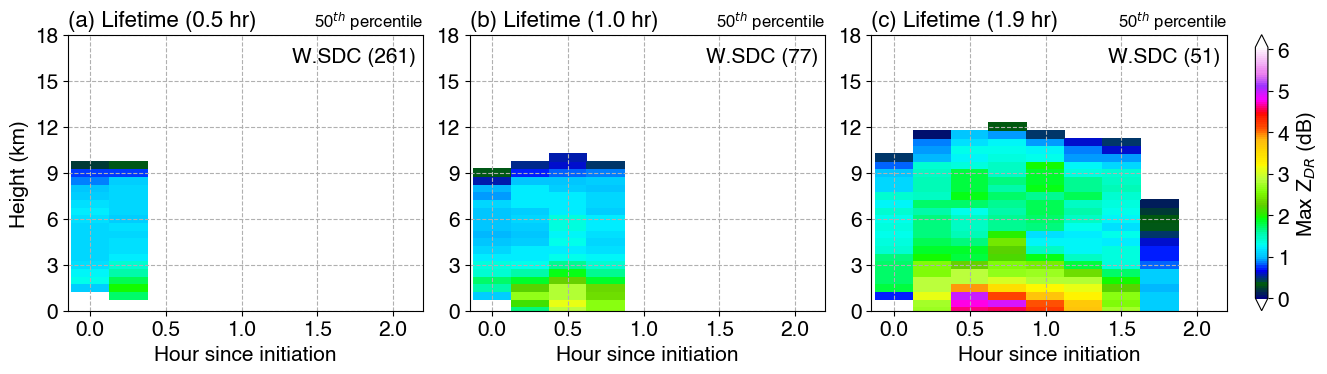

In [55]:
qntl = 0.5
legend = [f'W.SDC ({ntracks1_wSDC})', f'W.SDC ({ntracks2_wSDC})', f'W.SDC ({ntracks3_wSDC})']
dataarr = [max_zdr1_wSDC_pts.sel(quantile=qntl).transpose(), max_zdr2_wSDC_pts.sel(quantile=qntl).transpose(), max_zdr3_wSDC_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(1, 10.1, 0.1)
# cbticks = np.arange(1, 10.1, 1)
levels = np.arange(0, 6.1, 0.05)
cbticks = np.arange(0, 6.1, 1)
cmap = 'gist_ncar'
cblabel = 'Max Z$_{DR}$ (dB)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxzdr_{qntl*100:.0f}quantile_wSDC.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

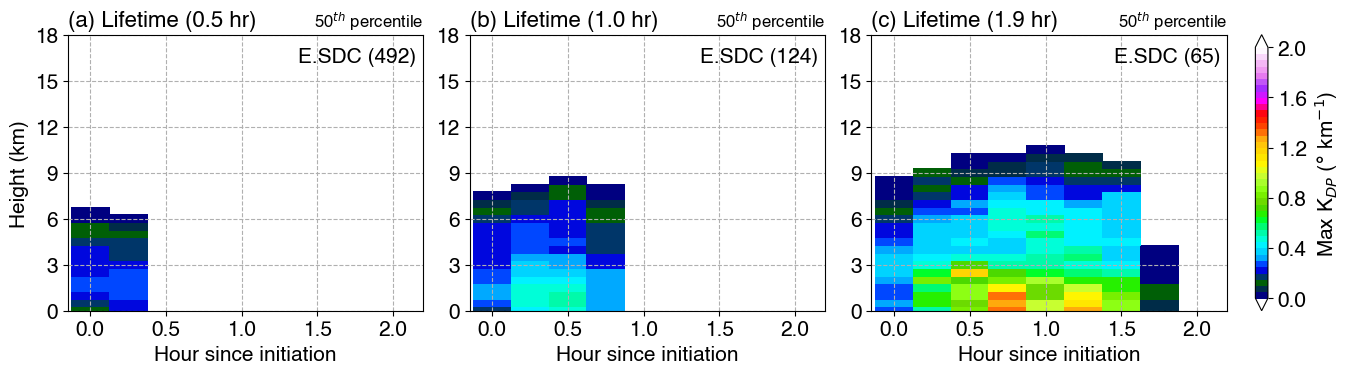

In [56]:
qntl = 0.5
legend = [f'E.SDC ({ntracks1_eSDC})', f'E.SDC ({ntracks2_eSDC})', f'E.SDC ({ntracks3_eSDC})']
dataarr = [max_kdp1_eSDC_pts.sel(quantile=qntl).transpose(), max_kdp2_eSDC_pts.sel(quantile=qntl).transpose(), max_kdp3_eSDC_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(0, 6.51, 0.1)
# cbticks = np.arange(0, 6.51, 1)
levels = np.arange(0, 2.01, 0.05)
cbticks = np.arange(0, 2.01, 0.4)
cmap = 'gist_ncar'
cblabel = 'Max K$_{DP}$ ($\degree$ km$^{-1}$)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxkdp_{qntl*100:.0f}quantile_eSDC.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

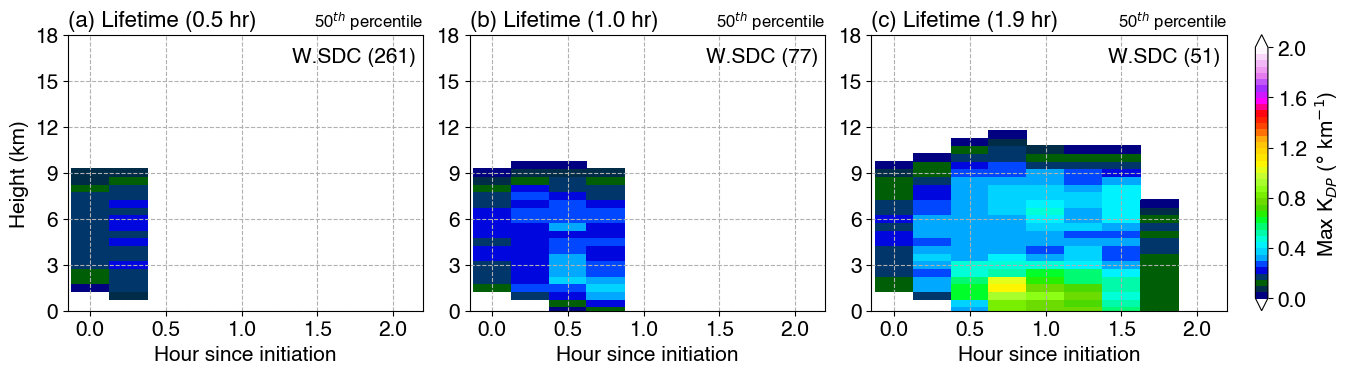

In [57]:
qntl = 0.5
legend = [f'W.SDC ({ntracks1_wSDC})', f'W.SDC ({ntracks2_wSDC})', f'W.SDC ({ntracks3_wSDC})']
dataarr = [max_kdp1_wSDC_pts.sel(quantile=qntl).transpose(), max_kdp2_wSDC_pts.sel(quantile=qntl).transpose(), max_kdp3_wSDC_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(0, 6.51, 0.1)
# cbticks = np.arange(0, 6.51, 1)
levels = np.arange(0, 2.01, 0.05)
cbticks = np.arange(0, 2.01, 0.4)
cmap = 'gist_ncar'
cblabel = 'Max K$_{DP}$ ($\degree$ km$^{-1}$)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxkdp_{qntl*100:.0f}quantile_wSDC.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

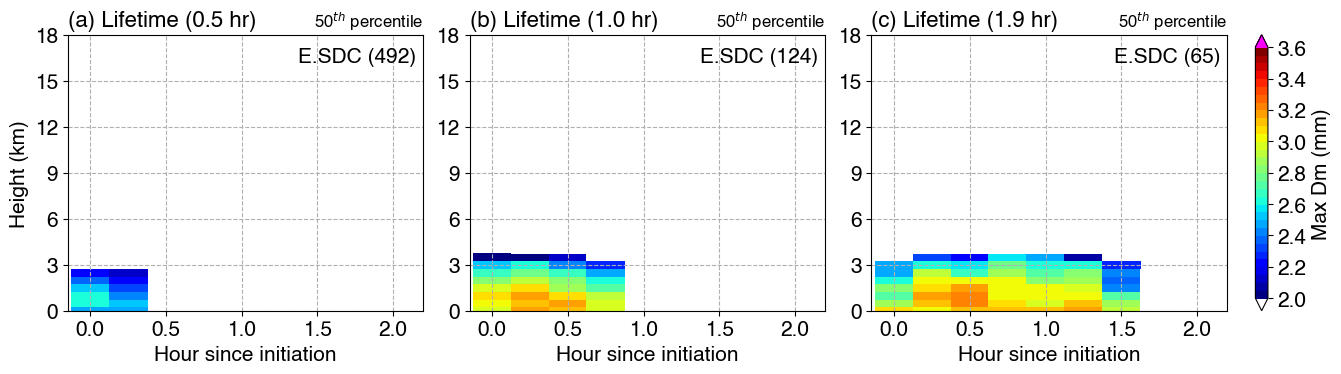

In [58]:
qntl = 0.5
legend = [f'E.SDC ({ntracks1_eSDC})', f'E.SDC ({ntracks2_eSDC})', f'E.SDC ({ntracks3_eSDC})']
dataarr = [max_Dm1_eSDC_pts.sel(quantile=qntl).transpose(), max_Dm2_eSDC_pts.sel(quantile=qntl).transpose(), max_Dm3_eSDC_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(3, 4.41, 0.05)
# cbticks = np.arange(3, 4.41, 0.2)
levels = np.arange(2, 3.61, 0.05)
cbticks = np.arange(2, 3.61, 0.2)
cmap = 'jet'
cblabel = 'Max Dm (mm)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxDm_{qntl*100:.0f}quantile_eSDC.png'
oob_colors = {'over':'magenta', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

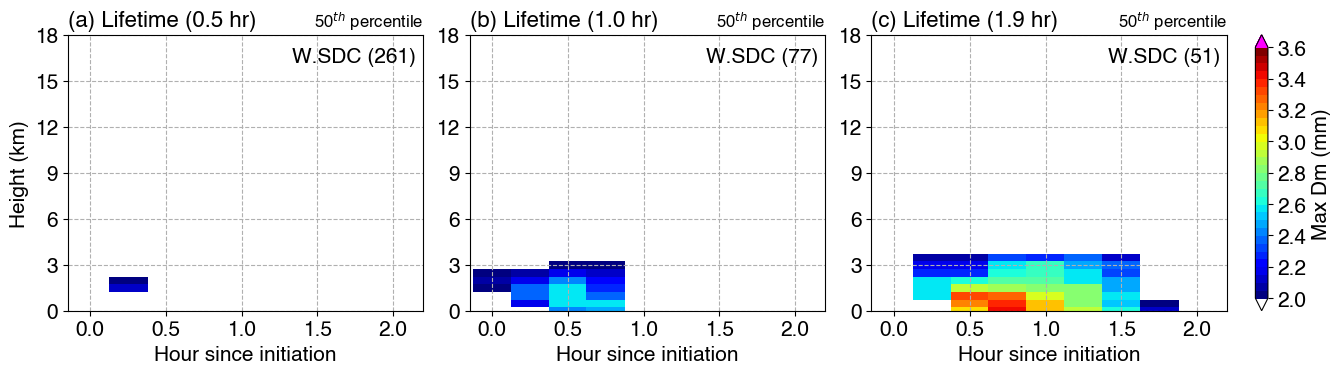

In [59]:
qntl = 0.5
legend = [f'W.SDC ({ntracks1_wSDC})', f'W.SDC ({ntracks2_wSDC})', f'W.SDC ({ntracks3_wSDC})']
dataarr = [max_Dm1_wSDC_pts.sel(quantile=qntl).transpose(), max_Dm2_wSDC_pts.sel(quantile=qntl).transpose(), max_Dm3_wSDC_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(3, 4.41, 0.05)
# cbticks = np.arange(3, 4.41, 0.2)
levels = np.arange(2, 3.61, 0.05)
cbticks = np.arange(2, 3.61, 0.2)
cmap = 'jet'
cblabel = 'Max Dm (mm)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxDm_{qntl*100:.0f}quantile_wSDC.png'
oob_colors = {'over':'magenta', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

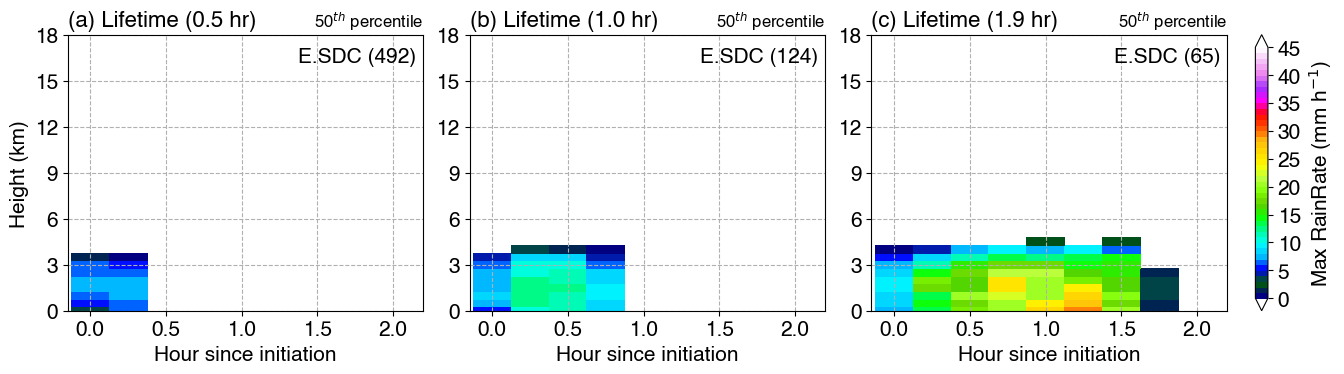

In [60]:
qntl = 0.5
legend = [f'E.SDC ({ntracks1_eSDC})', f'E.SDC ({ntracks2_eSDC})', f'E.SDC ({ntracks3_eSDC})']
dataarr = [max_rainrate1_eSDC_pts.sel(quantile=qntl).transpose(), max_rainrate2_eSDC_pts.sel(quantile=qntl).transpose(), max_rainrate3_eSDC_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(10, 120.1, 5)
# cbticks = np.arange(10, 120.1, 10)
levels = np.arange(0, 45.1, 1)
cbticks = np.arange(0, 45.1, 5)
cmap = 'gist_ncar'
cblabel = 'Max RainRate (mm h$^{-1}$)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxrainrate_{qntl*100:.0f}quantile_eSDC.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [ ]:
qntl = 0.5
legend = [f'W.SDC ({ntracks1_wSDC})', f'W.SDC ({ntracks2_wSDC})', f'W.SDC ({ntracks3_wSDC})']
dataarr = [max_rainrate1_wSDC_pts.sel(quantile=qntl).transpose(), max_rainrate2_wSDC_pts.sel(quantile=qntl).transpose(), max_rainrate3_wSDC_pts.sel(quantile=qntl).transpose()]
# levels = np.arange(10, 120.1, 5)
# cbticks = np.arange(10, 120.1, 10)
levels = np.arange(0, 45.1, 1)
cbticks = np.arange(0, 45.1, 5)
cmap = 'gist_ncar'
cblabel = 'Max RainRate (mm h$^{-1}$)'
figname = f'{figdir}celltrack_composite_profile_evolution_maxrainrate_{qntl*100:.0f}quantile_wSDC.png'
oob_colors = {'over':'white', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [ ]:
qntl = 0.5
legend = [f'E.SDC ({ntracks1_eSDC})', f'E.SDC ({ntracks2_eSDC})', f'E.SDC ({ntracks3_eSDC})']
scale = 1e6
dataarr = [volrain1_eSDC_pts.sel(quantile=qntl).transpose()/scale, volrain2_eSDC_pts.sel(quantile=qntl).transpose()/scale, volrain3_eSDC_pts.sel(quantile=qntl).transpose()/scale]
# levels = np.arange(0, 7.1, 0.05)
# cbticks = np.arange(0, 7.1, 1)
levels = np.arange(0, 1.001, 0.01)
cbticks = np.arange(0, 1.001, 0.2)
cmap = 'jet'
cblabel = 'Vol. Rain (10$^6$ m$^3$ h$^{-1}$)'
figname = f'{figdir}celltrack_composite_profile_evolution_volrain_{qntl*100:.0f}quantile_eSDC.png'
oob_colors = {'over':'darkviolet', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)

In [ ]:
qntl = 0.5
legend = [f'W.SDC ({ntracks1_wSDC})', f'W.SDC ({ntracks2_wSDC})', f'W.SDC ({ntracks3_wSDC})']
scale = 1e6
dataarr = [volrain1_wSDC_pts.sel(quantile=qntl).transpose()/scale, volrain2_wSDC_pts.sel(quantile=qntl).transpose()/scale, volrain3_wSDC_pts.sel(quantile=qntl).transpose()/scale]
# levels = np.arange(0, 7.1, 0.05)
# cbticks = np.arange(0, 7.1, 1)
levels = np.arange(0, 1.001, 0.01)
cbticks = np.arange(0, 1.001, 0.2)
cmap = 'jet'
cblabel = 'Vol. Rain (10$^6$ m$^3$ h$^{-1}$)'
figname = f'{figdir}celltrack_composite_profile_evolution_volrain_{qntl*100:.0f}quantile_wSDC.png'
oob_colors = {'over':'darkviolet', 'under':'white'}
fig = plot_timeheight_3panel(times_hour, height, dataarr, levels, cmap, xlims, ylims, yticks, titles, cblabel, cbticks, qntl*100, legend, figname, oob_colors=oob_colors)